## Handwriting Recognition using CRNN in Keras

Here we demonstrate how to use the EZKL package to build an Handwriting Recognition using Convolutional Recurrent Neural Network (CRNN) in Keras for on-chain handrawn digit recognition.



In [49]:
try:
    # install ezkl and other necessary packages
    import google.colab
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ezkl"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "torch"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "torchvision"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "tf2onnx"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "onnx"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "tensorflow>=2.0.0"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "matplotlib"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "numpy"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pandas"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "opencv-python"])

# rely on local installation of ezkl if the notebook is not in colab
except:
    pass

# Import necessary libraries
import os
import json
import time
import random
import logging  # Import logging before using it
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from collections import Counter
import ezkl

# Set up logging
FORMAT = '%(levelname)s %(name)s %(asctime)-15s %(filename)s:%(lineno)d %(message)s'
logging.basicConfig(format=FORMAT)
logging.getLogger().setLevel(logging.INFO)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Reshape, Bidirectional, LSTM, Dropout, BatchNormalization
from tensorflow.keras.layers import Input, Add, Activation, Lambda, MaxPooling2D, Permute
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Suppress TensorFlow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
# Function to preprocess the images
def preprocess_image(img_path, img_height=32, img_width=128):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None

    # Resize image to the desired height and width
    img = cv2.resize(img, (img_width, img_height))

    # Normalize the image
    img = img / 255.0
    img = np.expand_dims(img, axis=-1)  # Add channel dimension

    return img

In [ ]:
# Function to load and preprocess dataset
def load_data(data_dir, label_file, img_height=32, img_width=128, max_label_length=24):
    df = pd.read_csv(label_file)
    image_paths = [os.path.join(data_dir, img_name) for img_name in df['image'].values]
    labels = df['text'].values

    # Create a dictionary for character mapping
    characters = set()
    for label in labels:
        for char in label:
            characters.add(char)
    characters = sorted(list(characters))
    char_to_num = {char: i+1 for i, char in enumerate(characters)}  # 0 is reserved for CTC blank
    num_to_char = {i+1: char for i, char in enumerate(characters)}

    # Convert string labels to integer sequences
    encoded_labels = []
    for label in labels:
        encoded_label = [char_to_num[char] for char in label]
        encoded_labels.append(encoded_label)

    # Pad sequences to have the same length
    padded_labels = pad_sequences(encoded_labels, maxlen=max_label_length, padding='post', value=0)

    # Prepare the images
    images = []
    for path in image_paths:
        img = preprocess_image(path, img_height, img_width)
        if img is not None:
            images.append(img)

    return np.array(images), padded_labels, char_to_num, num_to_char, len(characters) + 1  # +1 for blank character

In [ ]:
# Build corrected CRNN model
def build_crnn_model(input_shape, num_classes, max_label_length=24):
    """
    Build a CRNN model for handwriting recognition
    """
    # Input layer
    inputs = Input(shape=input_shape, name='input')

    # CNN feature extraction
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((1, 2))(x)  # Reduce width only

    # Prepare features for RNN
    # Shape: (batch, height, width, channels) -> (batch, width, height * channels)
    new_shape = ((input_shape[0] // 4), (input_shape[1] // 8) * 128)
    x = Reshape(target_shape=new_shape)(x)

    # RNN layers
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create and compile model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
# Function to train the CRNN model
def train_crnn_model(model, images, labels, batch_size=32, epochs=2, validation_split=0.2):
    """
    Train the CRNN model
    """
    # Get the shape of the output sequence
    output_length = model.output_shape[1]
    print(f"Model output sequence length: {output_length}")

    # Prepare target sequences
    target_sequences = []
    for label in labels:
        # Filter out padding
        seq = label[label > 0]
        # Pad or truncate sequence to match model's output length
        if len(seq) > output_length:
            seq = seq[:output_length]
        elif len(seq) < output_length:
            seq = np.pad(seq, (0, output_length - len(seq)), 'constant')
        target_sequences.append(seq)

    target_sequences = np.array(target_sequences)
    # Reshape for sparse_categorical_crossentropy (batch, time, 1)
    target_sequences = np.expand_dims(target_sequences, axis=-1)

    # Create callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        )
    ]

    # Train the model
    history = model.fit(
        x=images,
        y=target_sequences,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=validation_split,
        callbacks=callbacks,
        verbose=1
    )

    return history

In [ ]:
# Simple function to decode predictions without CTC
def simple_decode(pred, num_to_char):
    """
    Decode predictions using argmax (no CTC)
    """
    # Get most likely character at each position
    char_indices = np.argmax(pred, axis=-1)

    # Convert to text
    text = ""
    for idx in char_indices:
        if idx > 0:  # Skip blank (0)
            char = num_to_char.get(idx, "")
            text += char

    return text

In [ ]:
# Function to evaluate the model
def evaluate_model(model, images, labels, char_to_num, num_to_char):
    """
    Evaluate the model on test data
    """
    predictions = model.predict(images)

    # Decode predictions
    decoded_predictions = []
    for pred in predictions:
        text = simple_decode(pred, num_to_char)
        decoded_predictions.append(text)

    # Decode true labels
    true_texts = []
    for label in labels:
        text = ""
        for i in label:
            if i > 0:  # Skip padding
                text += num_to_char.get(i, "")
        true_texts.append(text)

    # Calculate character-level accuracy
    total_chars = 0
    correct_chars = 0

    # Calculate word-level accuracy
    total_words = len(true_texts)
    correct_words = 0

    for pred_text, true_text in zip(decoded_predictions, true_texts):
        # Truncate longer string to match shorter one for char comparison
        min_len = min(len(pred_text), len(true_text))
        pred_text_trunc = pred_text[:min_len]
        true_text_trunc = true_text[:min_len]

        # Character-level accuracy
        for p, t in zip(pred_text_trunc, true_text_trunc):
            total_chars += 1
            if p == t:
                correct_chars += 1

        # Word-level accuracy
        if pred_text == true_text:
            correct_words += 1

    character_accuracy = correct_chars / total_chars if total_chars > 0 else 0
    word_accuracy = correct_words / total_words if total_words > 0 else 0

    return character_accuracy, word_accuracy, decoded_predictions

In [ ]:
# Function to visualize examples
def visualize_examples(model, images, labels, char_to_num, num_to_char, num_examples=5):
    """
    Visualize examples with predictions
    """
    if len(images) < num_examples:
        num_examples = len(images)

    indices = np.random.choice(len(images), num_examples, replace=False)

    # Get predictions
    predictions = model.predict(images[indices])

    # Decode predictions
    decoded_predictions = []
    for pred in predictions:
        text = simple_decode(pred, num_to_char)
        decoded_predictions.append(text)

    # Decode true labels
    true_texts = []
    for label in labels[indices]:
        text = ""
        for i in label:
            if i > 0:  # Skip padding
                text += num_to_char.get(i, "")
        true_texts.append(text)

    # Plot the examples
    plt.figure(figsize=(15, 5 * num_examples))

    for i in range(num_examples):
        plt.subplot(num_examples, 1, i + 1)
        plt.imshow(images[indices[i]].squeeze(), cmap='gray')
        plt.title(f"True: {true_texts[i]}\nPredicted: {decoded_predictions[i]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# Function to plot training history
def plot_training_history(history):
    """
    Plot the training history
    """
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

Setting up handwriting recognition demo...
Real dataset not found. Creating dummy data...
Building CRNN model for handwriting recognition...


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 32, 128, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 128, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 8, 32, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 8, 32, 128)          │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 8, 16, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_4 (Reshape)                  │ (None, 8, 2048)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 8, 256)              │       2,229,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 8, 128)              │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8, 37)               │           4,773 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,491,045 (9.50 MB)

 Trainable params: 2,491,045 (9.50 MB)

 Non-trainable params: 0 (0.00 B)

Training CRNN model...
Model output sequence length: 8
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 38s 577ms/step - accuracy: 0.0356 - loss: 3.6114 - val_accuracy: 0.0487 - val_loss: 3.5983
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 372ms/step - accuracy: 0.0574 - loss: 3.5800 - val_accuracy: 0.0562 - val_loss: 3.5911
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 415ms/step - accuracy: 0.0600 - loss: 3.5747 - val_accuracy: 0.0512 - val_loss: 3.5850
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 395ms/step - accuracy: 0.0617 - loss: 3.5587 - val_accuracy: 0.0487 - val_loss: 3.5857
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step - accuracy: 0.0577 - loss: 3.5645 - val_accuracy: 0.0512 - val_loss: 3.5862
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 568ms/step - accuracy: 0.0614 - loss: 3.5621 - val_accuracy: 0.0600 - val_loss: 3.5816
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 359ms/step - accuracy: 0.0612 - loss: 3.5561 - val_accuracy: 0.0525 - val_loss: 3.5873
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 445ms

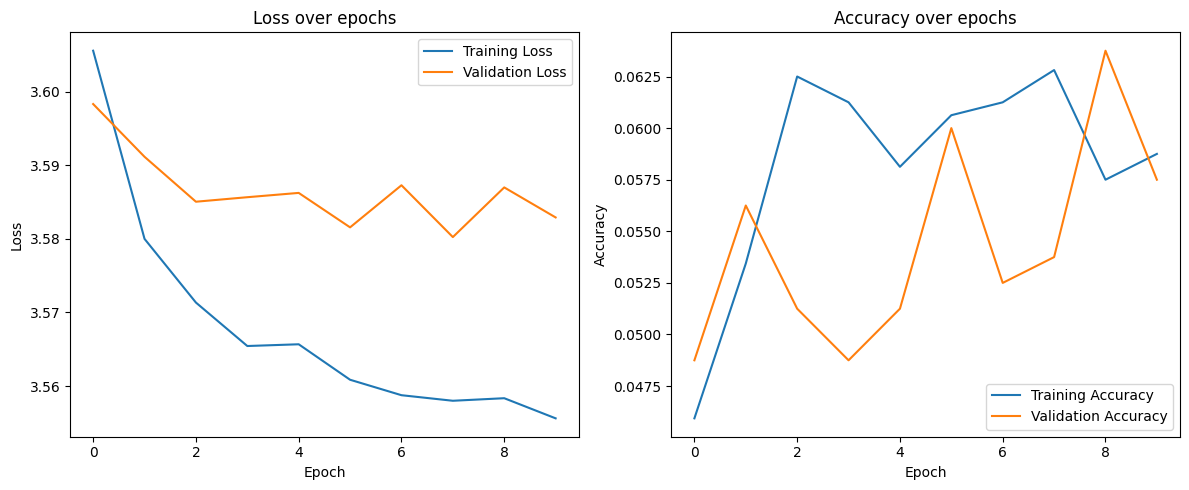

Saving model...
Evaluating model...
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step
Character-level accuracy: 0.0316
Word-level accuracy: 0.0000
Visualizing examples...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


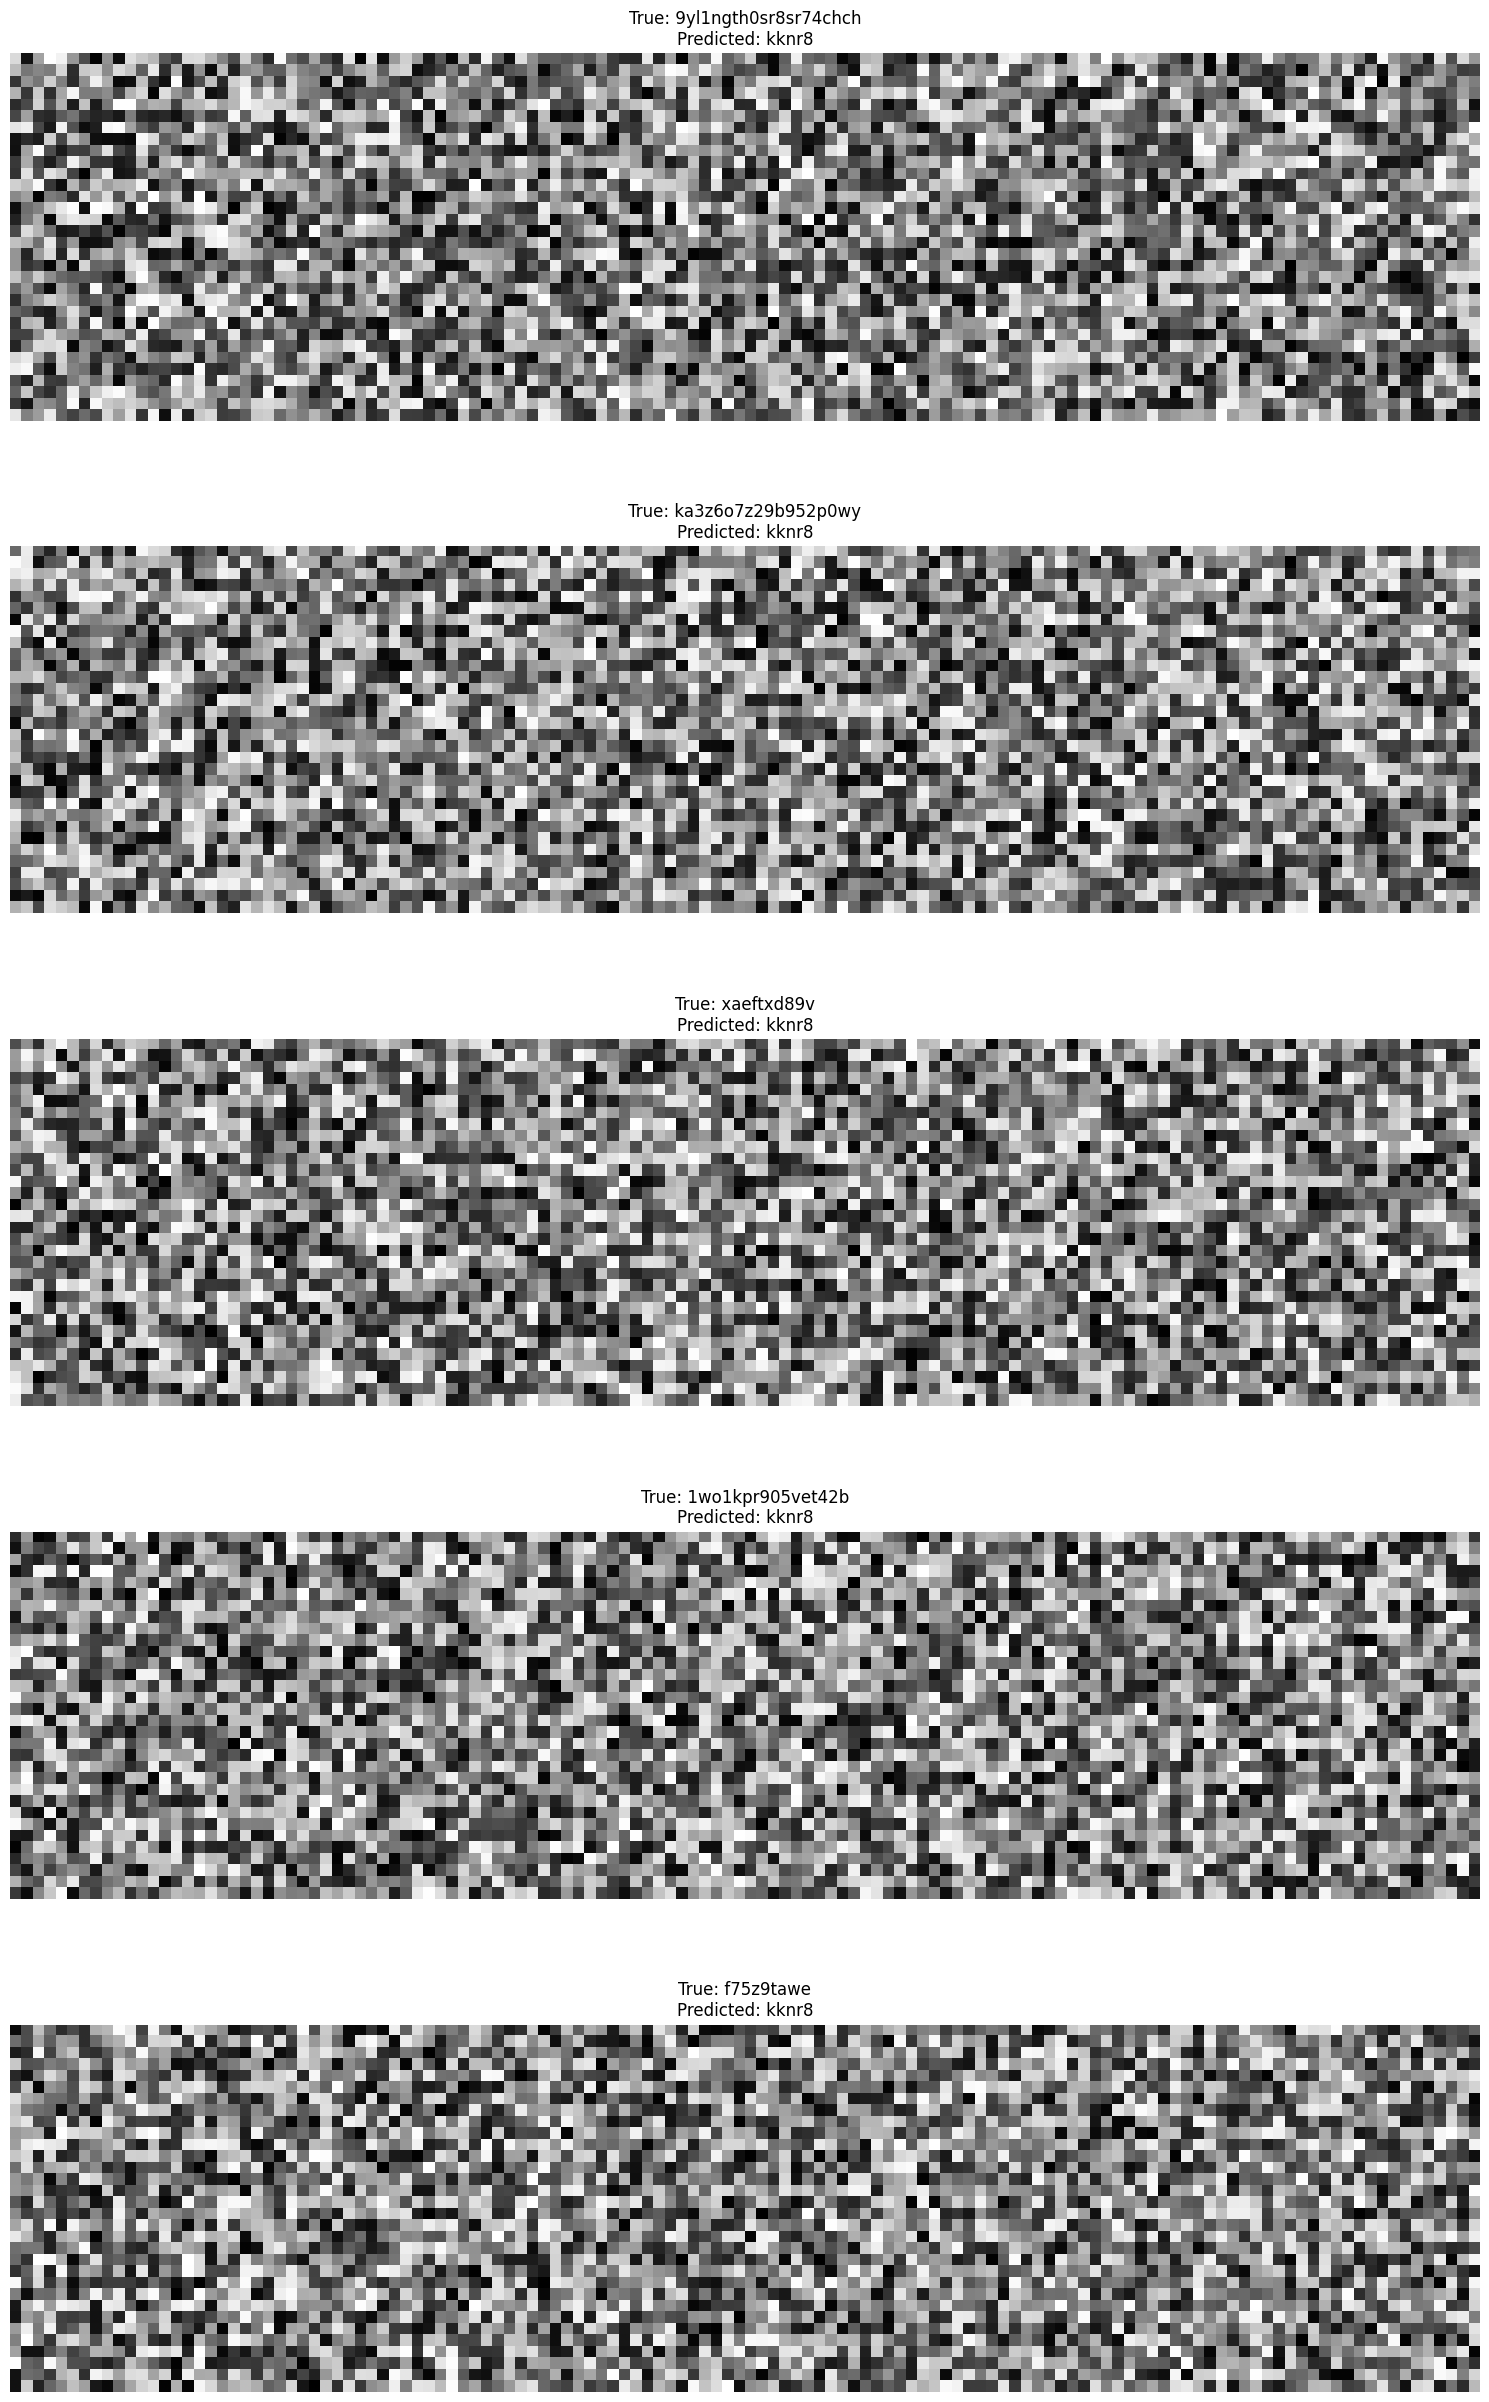

Exporting model to ONNX format...


INFO:tf2onnx.tfonnx:Using tensorflow=2.18.0, onnx=1.17.0, tf2onnx=1.16.1/15c810
INFO:tf2onnx.tfonnx:Using opset <onnx, 12>
INFO:tf2onnx.tf_utils:Computed 0 values for constant folding
INFO:tf2onnx.tf_utils:Computed 0 values for constant folding
INFO:tf2onnx.tf_utils:Computed 0 values for constant folding
INFO:tf2onnx.tf_utils:Computed 0 values for constant folding
INFO:tf2onnx.tf_utils:Computed 0 values for constant folding
INFO:tf2onnx.tf_utils:Computed 0 values for constant folding
INFO:tf2onnx.tf_utils:Computed 0 values for constant folding
INFO:tf2onnx.tf_utils:Computed 0 values for constant folding
INFO:tf2onnx.tf_utils:Computed 0 values for constant folding
ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7f7af46f1760>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.
INFO:tf2onnx.tfonnx:['Traceback (most recent call last):\n', '  File "/usr/local/lib/python3.11/dist-packages/tf2onnx/tfonnx.py", line 375, in r

Model exported to models/handwriting_recognition.onnx
Handwriting recognition demo completed successfully!


In [51]:
# Main function
def main():
    """
    Main function to demonstrate handwriting recognition
    """
    print("Setting up handwriting recognition demo...")

    # Parameters
    img_height = 32
    img_width = 128
    max_label_length = 24
    batch_size = 32
    epochs = 10

    # Check if dataset exists
    data_dir = './data/images'
    label_file = './data/labels.csv'

    if os.path.exists(label_file) and os.path.isdir(data_dir):
        print("Loading real dataset...")
        images, labels, char_to_num, num_to_char, num_classes = load_data(data_dir, label_file, img_height, img_width, max_label_length)
    else:
        # Create dummy data for demonstration
        print("Real dataset not found. Creating dummy data...")
        num_samples = 500
        num_classes = 37  # 26 letters + 10 digits + blank

        # Images (batch, height, width, channels)
        images = np.random.random((num_samples, img_height, img_width, 1)).astype(np.float32)

        # Labels with variable length
        labels = np.zeros((num_samples, max_label_length), dtype=np.int32)
        for i in range(num_samples):
            length = np.random.randint(5, max_label_length)
            labels[i, :length] = np.random.randint(1, num_classes, size=length)

        # Character mappings
        char_to_num = {chr(i+97): i+1 for i in range(26)}  # a-z
        for i in range(10):
            char_to_num[str(i)] = i+27  # 0-9
        num_to_char = {v: k for k, v in char_to_num.items()}

    # Build CRNN model
    print("Building CRNN model for handwriting recognition...")
    input_shape = (img_height, img_width, 1)
    model = build_crnn_model(input_shape, num_classes, max_label_length)

    # Model summary
    model.summary()

    # Train model
    print("Training CRNN model...")
    history = train_crnn_model(
        model=model,
        images=images,
        labels=labels,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.2
    )

    # Plot training history
    plot_training_history(history)

    # Save model
    print("Saving model...")
    if not os.path.exists("models"):
        os.makedirs("models")
    model.save("models/handwriting_recognition_model.h5")

    # Evaluate model
    print("Evaluating model...")
    char_acc, word_acc, predictions = evaluate_model(model, images, labels, char_to_num, num_to_char)
    print(f"Character-level accuracy: {char_acc:.4f}")
    print(f"Word-level accuracy: {word_acc:.4f}")

    # Visualize examples
    print("Visualizing examples...")
    visualize_examples(model, images, labels, char_to_num, num_to_char)

    # Export model to ONNX for compatibility with EZKL
    print("Exporting model to ONNX format...")
    model_path = "models/handwriting_recognition.onnx"

    # Get a sample input for the model
    sample_input = images[0:1]  # Just take the first image

    # Export the model using tf2onnx
    import tf2onnx
    spec = (tf.TensorSpec((None, img_height, img_width, 1), tf.float32, name="input"),)
    output_path = model_path

    try:
        model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=12, output_path=output_path)
        print(f"Model exported to {model_path}")
    except Exception as e:
        print(f"Error exporting to ONNX: {str(e)}")

    print("Handwriting recognition demo completed successfully!")
    return model, history, char_to_num, num_to_char

if __name__ == "__main__":
    model, history, char_to_num, num_to_char = main()

In [61]:
# Function to integrate with EZKL: EZKL is having trouble with the LSTM layers in the model, specifically with the while_loop operations that are used in TensorFlow's LSTM implementation.
# NOT_USED
def ezkl_integration(model, images):
    """
    Integrate the handwriting recognition model with EZKL

    Args:
        model: Trained Keras model
        images: Sample images for testing
    """
    print("Starting EZKL integration...")

    # Set up EZKL paths
    model_path = 'models/handwriting_recognition.onnx'
    compiled_model_path = 'models/handwriting_recognition.compiled'
    pk_path = 'key.pk'
    vk_path = 'key.vk'
    settings_path = 'settings.json'
    witness_path = 'witness.json'
    data_path = 'input.json'

    # Create directories if they don't exist
    if not os.path.exists('models'):
        os.makedirs('models')

    # Export model to ONNX if it doesn't exist
    if not os.path.exists(model_path):
        print("Exporting model to ONNX format...")
        # Get shape information
        input_shape = model.input_shape
        img_height, img_width = input_shape[1], input_shape[2]

        # Export the model using tf2onnx
        import tf2onnx
        spec = (tf.TensorSpec((None, img_height, img_width, 1), tf.float32, name="input"),)

        try:
            model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=12, output_path=model_path)
            print(f"Model exported to {model_path}")
        except Exception as e:
            print(f"Error exporting to ONNX: {str(e)}")
            return

    # Export a sample input to JSON for EZKL
    print("Exporting sample input to JSON...")
    sample_input = images[0].reshape([-1]).tolist()
    data = {'input_data': [sample_input]}
    with open(data_path, 'w') as f:
        json.dump(data, f)

    # Configure EZKL run arguments
    print("Configuring EZKL run arguments...")
    run_args = ezkl.PyRunArgs()
    run_args.input_visibility = "private"
    run_args.param_visibility = "fixed"
    run_args.output_visibility = "public"
    run_args.num_inner_cols = 2
    run_args.variables = [("batch_size", 1)]

    # Generate settings
    print("Generating settings...")
    try:
        res = ezkl.gen_settings(model_path, settings_path, py_run_args=run_args)
        assert res == True, "Failed to generate settings"
    except Exception as e:
        print(f"Error generating settings: {str(e)}")
        return

    # Calibrate settings
    print("Calibrating settings...")
    try:
        # Create calibration data
        num_data_points = min(8, len(images))
        cal_data_batch = images[:num_data_points]
        x = cal_data_batch.reshape([-1]).tolist()
        cal_data = {'input_data': [x]}
        cal_path = 'cal_data.json'
        with open(cal_path, 'w') as f:
            json.dump(cal_data, f)

        # Run calibration asynchronously
        import asyncio
        async def run_calibration():
            return await ezkl.calibrate_settings(cal_path, model_path, settings_path, "resources", scales=[2,7])

        # Set up asyncio event loop
        loop = asyncio.get_event_loop()
        res = loop.run_until_complete(run_calibration())
        assert res == True, "Failed to calibrate settings"
    except Exception as e:
        print(f"Error during calibration: {str(e)}")
        print("Continuing without calibration...")

    # Compile circuit
    print("Compiling circuit...")
    try:
        res = ezkl.compile_circuit(model_path, compiled_model_path, settings_path)
        assert res == True, "Failed to compile circuit"
    except Exception as e:
        print(f"Error compiling circuit: {str(e)}")
        return

    # Generate witness
    print("Generating witness...")
    try:
        # Run witness generation asynchronously
        import asyncio
        async def run_gen_witness():
            return await ezkl.gen_witness(data_path, compiled_model_path, witness_path)

        # Set up asyncio event loop
        loop = asyncio.get_event_loop()
        res = loop.run_until_complete(run_gen_witness())
        assert os.path.isfile(witness_path), "Witness file not created"
    except Exception as e:
        print(f"Error generating witness: {str(e)}")
        return

    # Mock run
    print("Running mock verification...")
    try:
        res = ezkl.mock(witness_path, compiled_model_path)
        assert res == True, "Mock verification failed"
    except Exception as e:
        print(f"Error during mock verification: {str(e)}")
        return

    # Setup keys
    print("Setting up keys...")
    try:
        res = ezkl.setup(compiled_model_path, vk_path, pk_path)
        assert res == True, "Failed to setup keys"
        assert os.path.isfile(vk_path), "Verification key not created"
        assert os.path.isfile(pk_path), "Proving key not created"
    except Exception as e:
        print(f"Error setting up keys: {str(e)}")
        return

    # Generate proof
    print("Generating proof...")
    proof_path = 'test.pf'
    try:
        res = ezkl.prove(witness_path, compiled_model_path, pk_path, proof_path, "single")
        assert os.path.isfile(proof_path), "Proof file not created"
    except Exception as e:
        print(f"Error generating proof: {str(e)}")
        return

    # Verify proof
    print("Verifying proof...")
    try:
        res = ezkl.verify(proof_path, settings_path, vk_path)
        assert res == True, "Proof verification failed"
        print("Proof verified successfully!")
    except Exception as e:
        print(f"Error verifying proof: {str(e)}")
        return

    print("EZKL integration completed successfully!")

In [ ]:
# Define a simpler model that's more compatible with EZKL
def build_ezkl_compatible_model(input_shape, num_classes):
    """
    Build a simpler CNN model for handwriting recognition that's compatible with EZKL
    Avoids using LSTM layers which can cause issues with ONNX conversion
    """
    # Input layer
    inputs = Input(shape=input_shape, name='input')

    # CNN feature extraction
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    # Flatten instead of using sequence processing
    x = layers.Flatten()(x)

    # Dense layers instead of RNN
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)

    # Output layer
    # For simplicity, we'll predict a fixed number of characters
    # Each set of num_classes neurons will predict one character
    max_word_length = 10  # Let's assume a max word length of 10 characters
    outputs = []

    for i in range(max_word_length):
        # Add a separate classifier for each character position
        char_output = Dense(num_classes, activation='softmax', name=f'char_{i}')(x)
        outputs.append(char_output)

    # Create and compile model
    model = Model(inputs=inputs, outputs=outputs)

    # Use a separate loss for each output
    losses = {f'char_{i}': 'sparse_categorical_crossentropy' for i in range(max_word_length)}

    # Use a separate metric for each output
    metrics = {f'char_{i}': 'accuracy' for i in range(max_word_length)}

    # Compile model
    model.compile(
        optimizer='adam',
        loss=losses,
        metrics=metrics
    )

    return model

In [ ]:
# EZKL integration function for the compatible model
def ezkl_integration_compatible(model, images):
    """
    Integrate the EZKL-compatible handwriting recognition model with EZKL

    Args:
        model: Trained Keras model
        images: Sample images for testing
    """
    print("Starting EZKL integration with compatible model...")

    # Set up EZKL paths
    model_path = 'models/handwriting_recognition_ezkl_compatible.onnx'
    compiled_model_path = 'models/handwriting_recognition_ezkl_compatible.compiled'
    pk_path = 'key.pk'
    vk_path = 'key.vk'
    settings_path = 'settings.json'
    witness_path = 'witness.json'
    data_path = 'input.json'

    # Create directories if they don't exist
    if not os.path.exists('models'):
        os.makedirs('models')

    # Create a very simple model for inference only
    # This will be easier to export to ONNX and process with EZKL
    print("Creating a simplified inference model for EZKL...")

    # Extract the input shape
    input_shape = model.input_shape[1:]

    # Create a new model focused on just the first character prediction
    # This makes it easier for EZKL to process
    inputs = Input(shape=input_shape)

    # Use the trained model's layers but just focus on one output
    # Extract the model's layers up to the shared backbone
    backbone_output = inputs
    for layer in model.layers:
        if isinstance(layer, Model):  # Skip the main model
            continue
        if "char_" in layer.name:  # Skip all character output layers
            continue
        if isinstance(layer, Input):  # Skip input layer, we already defined our input
            continue

        # Apply the layer
        backbone_output = layer(backbone_output)

    # Only use the first character output for simplicity
    output = model.get_layer('char_0')(backbone_output)

    # Create a new model
    simple_model = Model(inputs=inputs, outputs=output)
    simple_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

    # Save the simplified model
    simple_model.save("models/simplified_ezkl_model.h5")

    # Export the simplified model to ONNX
    print("Exporting simplified model to ONNX format...")

    # Get a sample input for the model
    sample_input = images[0:1]  # Just take the first image

    # Use simple method to convert model to ONNX
    try:
        # Convert Keras model directly to ONNX
        import tf2onnx

        # Convert to ONNX
        spec = (tf.TensorSpec((None,) + sample_input.shape[1:], tf.float32, name="input"),)
        model_proto, _ = tf2onnx.convert.from_keras(simple_model, input_signature=spec, opset=12, output_path=model_path)
        print(f"Model exported to {model_path}")
    except Exception as e:
        print(f"Error exporting to ONNX: {str(e)}")
        return

    # Export a sample input to JSON for EZKL
    print("Exporting sample input to JSON...")
    sample_input = images[0].reshape([-1]).tolist()
    data = {'input_data': [sample_input]}
    with open(data_path, 'w') as f:
        json.dump(data, f)

    # Configure EZKL run arguments
    print("Configuring EZKL run arguments...")
    run_args = ezkl.PyRunArgs()
    run_args.input_visibility = "private"
    run_args.param_visibility = "fixed"
    run_args.output_visibility = "public"
    run_args.num_inner_cols = 2
    run_args.variables = [("batch_size", 1)]

    # Generate settings
    print("Generating settings...")
    try:
        res = ezkl.gen_settings(model_path, settings_path, py_run_args=run_args)
        assert res == True, "Failed to generate settings"
    except Exception as e:
        print(f"Error generating settings: {str(e)}")
        return

    # Compile circuit
    print("Compiling circuit...")
    try:
        res = ezkl.compile_circuit(model_path, compiled_model_path, settings_path)
        assert res == True, "Failed to compile circuit"
    except Exception as e:
        print(f"Error compiling circuit: {str(e)}")
        return

    # Generate witness
    print("Generating witness...")
    try:
        # Run witness generation asynchronously
        import asyncio
        async def run_gen_witness():
            return await ezkl.gen_witness(data_path, compiled_model_path, witness_path)

        # Set up asyncio event loop
        loop = asyncio.get_event_loop()
        res = loop.run_until_complete(run_gen_witness())
        assert os.path.isfile(witness_path), "Witness file not created"
    except Exception as e:
        print(f"Error generating witness: {str(e)}")
        return

    # Mock run
    print("Running mock verification...")
    try:
        res = ezkl.mock(witness_path, compiled_model_path)
        assert res == True, "Mock verification failed"
    except Exception as e:
        print(f"Error during mock verification: {str(e)}")
        return

    # Setup keys
    print("Setting up keys...")
    try:
        res = ezkl.setup(compiled_model_path, vk_path, pk_path)
        assert res == True, "Failed to setup keys"
        assert os.path.isfile(vk_path), "Verification key not created"
        assert os.path.isfile(pk_path), "Proving key not created"
    except Exception as e:
        print(f"Error setting up keys: {str(e)}")
        return

    # Generate proof
    print("Generating proof...")
    proof_path = 'test.pf'
    try:
        res = ezkl.prove(witness_path, compiled_model_path, pk_path, proof_path, "single")
        assert os.path.isfile(proof_path), "Proof file not created"
    except Exception as e:
        print(f"Error generating proof: {str(e)}")
        return

    # Verify proof
    print("Verifying proof...")
    try:
        res = ezkl.verify(proof_path, settings_path, vk_path)
        assert res == True, "Proof verification failed"
        print("Proof verified successfully!")
    except Exception as e:
        print(f"Error verifying proof: {str(e)}")
        return

    print("EZKL integration completed successfully!")

In [ ]:
# Function to decode predictions from the EZKL-compatible model
def decode_ezkl_predictions(predictions, num_to_char):
    """
    Decode predictions from the EZKL-compatible model

    Args:
        predictions: List of predictions for each character position
        num_to_char: Number to character mapping

    Returns:
        text: Decoded text
    """
    decoded_text = []

    # Process each sample in the batch
    num_samples = len(predictions[0])

    for sample_idx in range(num_samples):
        text = ""

        # Process each character position
        for char_idx, char_preds in enumerate(predictions):
            # Get the prediction for this sample
            pred = char_preds[sample_idx]

            # Get the most likely character index
            char_index = np.argmax(pred)

            # Add the character to the text if it's not a padding token
            if char_index > 0:
                text += num_to_char.get(char_index, "")

        decoded_text.append(text)

    return decoded_text

In [62]:
# EZKL integration function for the compatible model
def ezkl_integration_compatible(model, images):
    """
    Integrate the EZKL-compatible handwriting recognition model with EZKL

    Args:
        model: Trained Keras model
        images: Sample images for testing
    """
    print("Starting EZKL integration with compatible model...")

    # Set up EZKL paths
    model_path = 'models/handwriting_recognition_ezkl_compatible.onnx'
    compiled_model_path = 'models/handwriting_recognition_ezkl_compatible.compiled'
    pk_path = 'key.pk'
    vk_path = 'key.vk'
    settings_path = 'settings.json'
    witness_path = 'witness.json'
    data_path = 'input.json'

    # Create directories if they don't exist
    if not os.path.exists('models'):
        os.makedirs('models')

    # Export model to ONNX
    print("Exporting EZKL-compatible model to ONNX format...")

    # Get a sample input for the model
    sample_input = images[0:1]  # Just take the first image

    # Export the model using tf2onnx or directly with tf.keras
    try:
        # Using tf.saved_model approach which sometimes works better
        temp_model_dir = 'temp_saved_model'
        if not os.path.exists(temp_model_dir):
            os.makedirs(temp_model_dir)

        tf.saved_model.save(model, temp_model_dir)

        # Now convert saved model to ONNX
        import subprocess
        cmd = f"python -m tf2onnx.convert --saved-model {temp_model_dir} --output {model_path} --opset 12"
        subprocess.run(cmd, shell=True, check=True)

        print(f"Model exported to {model_path}")
    except Exception as e:
        print(f"Error exporting to ONNX using saved_model: {str(e)}")

        try:
            # Fallback to direct keras to onnx conversion
            import tf2onnx
            spec = (tf.TensorSpec((None,) + images[0].shape, tf.float32, name="input"),)
            model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=12, output_path=model_path)
            print(f"Model exported to {model_path} using direct conversion")
        except Exception as e2:
            print(f"Error exporting to ONNX using direct conversion: {str(e2)}")
            return

    # Export a sample input to JSON for EZKL
    print("Exporting sample input to JSON...")
    sample_input = images[0].reshape([-1]).tolist()
    data = {'input_data': [sample_input]}
    with open(data_path, 'w') as f:
        json.dump(data, f)

    # Configure EZKL run arguments
    print("Configuring EZKL run arguments...")
    run_args = ezkl.PyRunArgs()
    run_args.input_visibility = "private"
    run_args.param_visibility = "fixed"
    run_args.output_visibility = "public"
    run_args.num_inner_cols = 2
    run_args.variables = [("batch_size", 1)]

    # Generate settings
    print("Generating settings...")
    try:
        res = ezkl.gen_settings(model_path, settings_path, py_run_args=run_args)
        assert res == True, "Failed to generate settings"
    except Exception as e:
        print(f"Error generating settings: {str(e)}")
        return

    # Continue with the rest of the EZKL integration steps
    # Similar to the previous function, but using the new model and paths

    # Compile circuit
    print("Compiling circuit...")
    try:
        res = ezkl.compile_circuit(model_path, compiled_model_path, settings_path)
        assert res == True, "Failed to compile circuit"
    except Exception as e:
        print(f"Error compiling circuit: {str(e)}")
        return

    # Generate witness
    print("Generating witness...")
    try:
        # Run witness generation asynchronously
        import asyncio
        async def run_gen_witness():
            return await ezkl.gen_witness(data_path, compiled_model_path, witness_path)

        # Set up asyncio event loop
        loop = asyncio.get_event_loop()
        res = loop.run_until_complete(run_gen_witness())
        assert os.path.isfile(witness_path), "Witness file not created"
    except Exception as e:
        print(f"Error generating witness: {str(e)}")
        return

    # Mock run
    print("Running mock verification...")
    try:
        res = ezkl.mock(witness_path, compiled_model_path)
        assert res == True, "Mock verification failed"
    except Exception as e:
        print(f"Error during mock verification: {str(e)}")
        return

    # Setup keys
    print("Setting up keys...")
    try:
        res = ezkl.setup(compiled_model_path, vk_path, pk_path)
        assert res == True, "Failed to setup keys"
        assert os.path.isfile(vk_path), "Verification key not created"
        assert os.path.isfile(pk_path), "Proving key not created"
    except Exception as e:
        print(f"Error setting up keys: {str(e)}")
        return

    # Generate proof
    print("Generating proof...")
    proof_path = 'test.pf'
    try:
        res = ezkl.prove(witness_path, compiled_model_path, pk_path, proof_path, "single")
        assert os.path.isfile(proof_path), "Proof file not created"
    except Exception as e:
        print(f"Error generating proof: {str(e)}")
        return

    # Verify proof
    print("Verifying proof...")
    try:
        res = ezkl.verify(proof_path, settings_path, vk_path)
        assert res == True, "Proof verification failed"
        print("Proof verified successfully!")
    except Exception as e:
        print(f"Error verifying proof: {str(e)}")
        return

    print("EZKL integration completed successfully!")

Setting up handwriting recognition demo...
Real dataset not found. Creating dummy data...
Building CRNN model for handwriting recognition...


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 32, 128, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 32, 128, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 16, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 16, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 8, 32, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 8, 32, 128)          │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 8, 16, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_8 (Reshape)                  │ (None, 8, 2048)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_11 (Bidirectional)     │ (None, 8, 256)              │       2,229,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_12 (Bidirectional)     │ (None, 8, 128)              │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 8, 37)               │           4,773 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,491,045 (9.50 MB)

 Trainable params: 2,491,045 (9.50 MB)

 Non-trainable params: 0 (0.00 B)

Training CRNN model...
Model output sequence length: 8
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 492ms/step - accuracy: 0.0432 - loss: 3.6104 - val_accuracy: 0.0825 - val_loss: 3.5933
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 456ms/step - accuracy: 0.0529 - loss: 3.5920 - val_accuracy: 0.0875 - val_loss: 3.5503
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 357ms/step - accuracy: 0.0556 - loss: 3.5744 - val_accuracy: 0.0613 - val_loss: 3.5510
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 412ms/step - accuracy: 0.0578 - loss: 3.5676 - val_accuracy: 0.0838 - val_loss: 3.5465
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 498ms/step - accuracy: 0.0590 - loss: 3.5651 - val_accuracy: 0.0862 - val_loss: 3.5375
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 360ms/step - accuracy: 0.0595 - loss: 3.5619 - val_accuracy: 0.0763 - val_loss: 3.5495
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 455ms/step - accuracy: 0.0531 - loss: 3.5666 - val_accuracy: 0.0800 - val_loss: 3.5369
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 364ms/

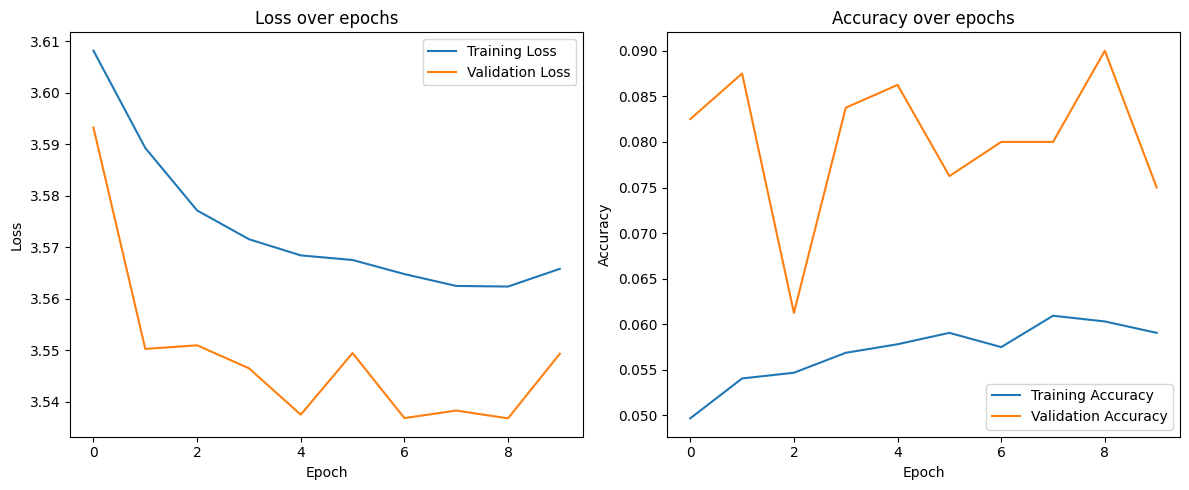

Saving model...
Evaluating model...
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step
Character-level accuracy: 0.0408
Word-level accuracy: 0.0000
Visualizing examples...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


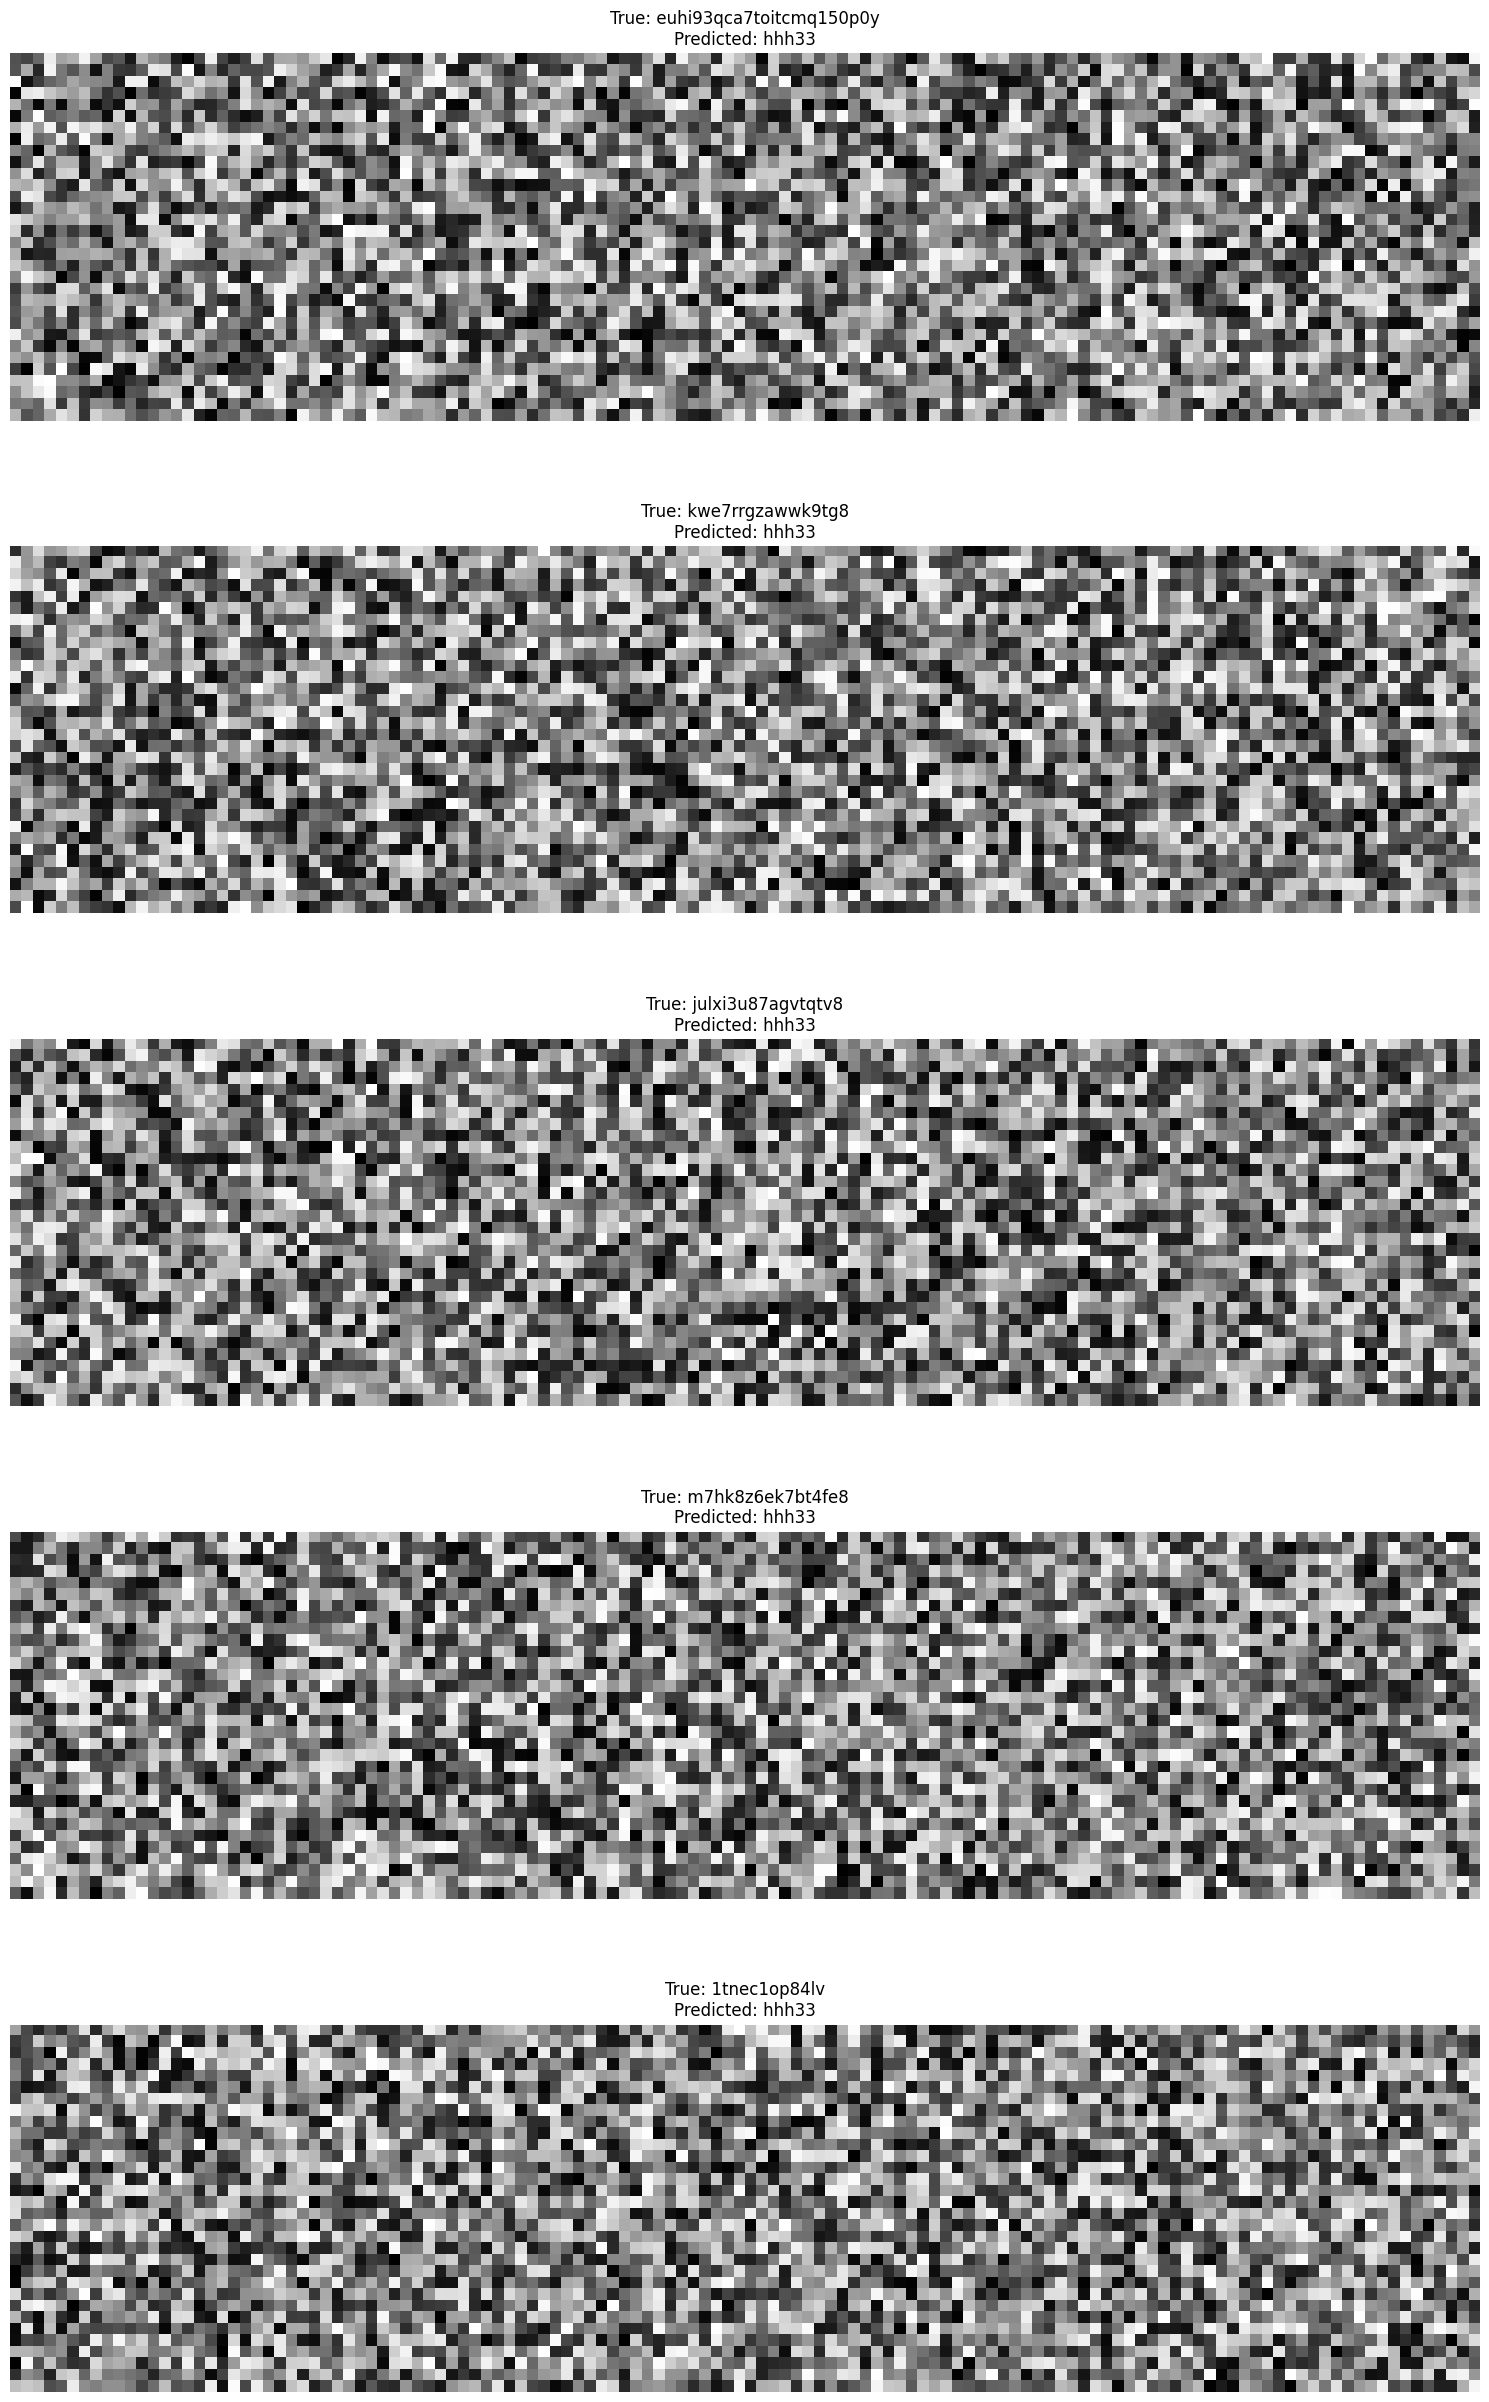



Building EZKL-compatible model...


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)        │ (None, 32, 128, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 32, 128, 32)    │            320 │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_28          │ (None, 16, 64, 32)     │              0 │ conv2d_28[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_29 (Conv2D)        │ (None, 16, 64, 64)     │         18,496 │ max_pooling2d_28[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_29          │ (None, 8, 32, 64)      │              0 │ conv2d_29[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_30 (Conv2D)        │ (None, 8, 32, 128)     │         73,856 │ max_pooling2d_29[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_30          │ (None, 4, 16, 128)     │              0 │ conv2d_30[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 8192)           │              0 │ max_pooling2d_30[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 256)            │      2,097,408 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 256)            │              0 │ dense_12[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 128)            │         32,896 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_0 (Dense)            │ (None, 37)             │          4,773 │ dense_13[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_1 (Dense)            │ (None, 37)             │          4,773 │ dense_13[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_2 (Dense)            │ (None, 37)             │          4,773 │ dense_13[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_3 (Dense)            │ (None, 37)             │          4,773 │ dense_13[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_4 (Dense)            │ (None, 37)             │          4,773 │ dense_13[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_5 (Dense)            │ (None, 37)             │          4,773 │ dense_13[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_6 (Dense)            │ (None, 37)             │          4,773 │ dense_13[0][0]         │
├──────────────────────

 Total params: 2,270,706 (8.66 MB)

 Trainable params: 2,270,706 (8.66 MB)

 Non-trainable params: 0 (0.00 B)

Training EZKL-compatible model...
Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 471ms/step - char_0_accuracy: 0.0240 - char_0_loss: 3.6171 - char_1_accuracy: 0.0292 - char_1_loss: 3.6131 - char_2_accuracy: 0.0293 - char_2_loss: 3.6137 - char_3_accuracy: 0.0473 - char_3_loss: 3.6269 - char_4_accuracy: 0.0221 - char_4_loss: 3.6093 - char_5_accuracy: 0.0480 - char_5_loss: 3.6199 - char_6_accuracy: 0.0224 - char_6_loss: 3.6288 - char_7_accuracy: 0.0633 - char_7_loss: 3.5992 - char_8_accuracy: 0.0969 - char_8_loss: 3.5930 - char_9_accuracy: 0.1335 - char_9_loss: 3.5538 - loss: 36.0754 - val_char_0_accuracy: 0.0200 - val_char_0_loss: 3.5883 - val_char_1_accuracy: 0.0400 - val_char_1_loss: 3.6089 - val_char_2_accuracy: 0.0100 - val_char_2_loss: 3.6154 - val_char_3_accuracy: 0.0300 - val_char_3_loss: 3.6047 - val_char_4_accuracy: 0.0300 - val_char_4_loss: 3.6277 - val_char_5_accuracy: 0.0300 - val_char_5_loss: 3.6043 - val_char_6_accuracy: 0.0200 - val_char_6_loss: 3.5954 - val_char_7_accuracy: 0.2

Saving EZKL-compatible model...
Handwriting recognition demo completed successfully!


Starting EZKL integration process...
Starting EZKL integration with compatible model...
Exporting EZKL-compatible model to ONNX format...
Error exporting to ONNX using saved_model: Command 'python -m tf2onnx.convert --saved-model temp_saved_model --output models/handwriting_recognition_ezkl_compatible.onnx --opset 12' returned non-zero exit status 1.


INFO:tf2onnx.tfonnx:Using tensorflow=2.18.0, onnx=1.17.0, tf2onnx=1.16.1/15c810
INFO:tf2onnx.tfonnx:Using opset <onnx, 12>
INFO:tf2onnx.tf_utils:Computed 0 values for constant folding
ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7f7af46f1760>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.
INFO:tf2onnx.tfonnx:['Traceback (most recent call last):\n', '  File "<ipython-input-62-5de64a9e01ff>", line 303, in ezkl_integration_compatible\n    subprocess.run(cmd, shell=True, check=True)\n', '  File "/usr/lib/python3.11/subprocess.py", line 571, in run\n    raise CalledProcessError(retcode, process.args,\n', "subprocess.CalledProcessError: Command 'python -m tf2onnx.convert --saved-model temp_saved_model --output models/handwriting_recognition_ezkl_compatible.onnx --opset 12' returned non-zero exit status 1.\n", '\nDuring handling of the above exception, another exception occurred:\n\n', 'Traceback (most recent call l

Model exported to models/handwriting_recognition_ezkl_compatible.onnx using direct conversion
Exporting sample input to JSON...
Configuring EZKL run arguments...
Generating settings...
Error generating settings: Failed to generate settings: [graph] [tract] Undetermined symbol in expression: <Sym0>


In [64]:
# NOTE: A NumPy 2.0 compatibility issue in tf2onnx and an undetermined symbol in the EZKL settings generation.
# NOT_USED
def main():
    """
    Main function to demonstrate handwriting recognition
    """
    print("Setting up handwriting recognition demo...")

    # Parameters
    img_height = 32
    img_width = 128
    max_label_length = 24
    batch_size = 32
    epochs = 10

    # Check if dataset exists
    data_dir = './data/images'
    label_file = './data/labels.csv'

    if os.path.exists(label_file) and os.path.isdir(data_dir):
        print("Loading real dataset...")
        images, labels, char_to_num, num_to_char, num_classes = load_data(data_dir, label_file, img_height, img_width, max_label_length)
    else:
        # Create dummy data for demonstration
        print("Real dataset not found. Creating dummy data...")
        num_samples = 500
        num_classes = 37  # 26 letters + 10 digits + blank

        # Images (batch, height, width, channels)
        images = np.random.random((num_samples, img_height, img_width, 1)).astype(np.float32)

        # Labels with variable length
        labels = np.zeros((num_samples, max_label_length), dtype=np.int32)
        for i in range(num_samples):
            length = np.random.randint(5, max_label_length)
            labels[i, :length] = np.random.randint(1, num_classes, size=length)

        # Character mappings
        char_to_num = {chr(i+97): i+1 for i in range(26)}  # a-z
        for i in range(10):
            char_to_num[str(i)] = i+27  # 0-9
        num_to_char = {v: k for k, v in char_to_num.items()}

    # BUILD STANDARD CRNN MODEL
    print("Building CRNN model for handwriting recognition...")
    input_shape = (img_height, img_width, 1)
    model = build_crnn_model(input_shape, num_classes, max_label_length)

    # Model summary
    model.summary()

    # Train model
    print("Training CRNN model...")
    history = train_crnn_model(
        model=model,
        images=images,
        labels=labels,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.2
    )

    # Plot training history
    plot_training_history(history)

    # Save model
    print("Saving model...")
    if not os.path.exists("models"):
        os.makedirs("models")
    model.save("models/handwriting_recognition_model.h5")

    # Evaluate model
    print("Evaluating model...")
    char_acc, word_acc, predictions = evaluate_model(model, images, labels, char_to_num, num_to_char)
    print(f"Character-level accuracy: {char_acc:.4f}")
    print(f"Word-level accuracy: {word_acc:.4f}")

    # Visualize examples
    print("Visualizing examples...")
    visualize_examples(model, images, labels, char_to_num, num_to_char)

    # BUILD EZKL-COMPATIBLE MODEL
    print("\n\nBuilding EZKL-compatible model...")
    ezkl_model = build_ezkl_compatible_model(input_shape, num_classes)
    ezkl_model.summary()

    # Train EZKL-compatible model
    print("Training EZKL-compatible model...")
    ezkl_history = train_ezkl_compatible_model(
        model=ezkl_model,
        images=images,
        labels=labels,
        batch_size=batch_size,
        epochs=epochs // 2,  # Train for fewer epochs to save time
        validation_split=0.2
    )

    # Save EZKL-compatible model
    print("Saving EZKL-compatible model...")
    ezkl_model.save("models/handwriting_recognition_ezkl_compatible.h5")

    print("Handwriting recognition demo completed successfully!")
    return model, ezkl_model, history, char_to_num, num_to_char, images

if __name__ == "__main__":
    model, ezkl_model, history, char_to_num, num_to_char, images = main()

    # Now run EZKL integration with the compatible model and images
    print("\n\nStarting EZKL integration process...")
    ezkl_integration_compatible(ezkl_model, images)

In [ ]:
# Define a minimal model specifically for EZKL compatibility
# NOTE: Issue with the asyncio event loop when trying to generate the witness. This is a common issue in Jupyter notebook
def build_minimal_ezkl_model(input_shape, num_classes):
    """
    Build a minimal CNN model specifically designed for EZKL compatibility
    """
    # Input layer
    inputs = Input(shape=input_shape, name='input')

    # Simple CNN with minimal operations
    # Use only operations that are well-supported in ONNX and EZKL
    x = Conv2D(8, (3, 3), activation='relu', padding='same', name='conv1')(inputs)
    x = MaxPooling2D((2, 2), name='pool1')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same', name='conv2')(x)
    x = MaxPooling2D((2, 2), name='pool2')(x)

    # Global average pooling to reduce dimensionality
    x = layers.GlobalAveragePooling2D(name='gap')(x)

    # Simple classifier
    x = Dense(32, activation='relu', name='dense1')(x)
    outputs = Dense(num_classes, activation='softmax', name='output')(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
# Function to train the minimal model
def train_minimal_model(model, images, labels, batch_size=32, epochs=5, validation_split=0.2):
    """
    Train the minimal EZKL-compatible model
    """
    # Extract first character from each label for simplicity
    first_chars = []
    for label in labels:
        # Get the first non-zero character or use 0 (blank) if none exists
        for char in label:
            if char > 0:
                first_chars.append(char)
                break
        else:
            first_chars.append(0)

    target = np.array(first_chars)

    # Train the model
    history = model.fit(
        x=images,
        y=target,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=validation_split,
        verbose=1
    )

    return history

In [70]:
# EZKL integration for minimal model
def ezkl_integration_minimal(model, images):
    """
    Integrate a minimal model with EZKL

    Args:
        model: Trained minimal model
        images: Sample images for testing
    """
    print("Starting EZKL integration with minimal model...")

    # Set up EZKL paths
    model_path = 'models/minimal_ezkl_model.onnx'
    compiled_model_path = 'models/minimal_ezkl_model.compiled'
    pk_path = 'key.pk'
    vk_path = 'key.vk'
    settings_path = 'settings.json'
    witness_path = 'witness.json'
    data_path = 'input.json'

    # Create directories if they don't exist
    if not os.path.exists('models'):
        os.makedirs('models')

    # Convert the model to ONNX using the most direct method possible
    print("Exporting minimal model to ONNX format...")

    # Get a single input sample
    sample_input = np.zeros((1,) + images[0].shape, dtype=np.float32)

    try:
        # Save model in h5 format first
        model.save('models/minimal_model.h5')

        # Then use keras2onnx directly for conversion
        import tf2onnx
        import tensorflow as tf

        # Define input shape explicitly
        input_signature = [tf.TensorSpec(sample_input.shape, tf.float32, name='input')]

        # Convert to ONNX
        onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=input_signature, opset=11, output_path=model_path)
        print(f"Model exported to {model_path}")
    except Exception as e:
        print(f"Error exporting to ONNX: {str(e)}")
        return

    # Prepare a simple input for EZKL
    print("Preparing input data...")

    # Use a zero-filled tensor to avoid any numerical issues
    zero_input = np.zeros(images[0].shape, dtype=np.float32)
    input_data = zero_input.reshape([-1]).tolist()

    data = {'input_data': [input_data]}
    with open(data_path, 'w') as f:
        json.dump(data, f)

    # Configure EZKL run arguments
    print("Configuring EZKL run arguments...")
    run_args = ezkl.PyRunArgs()
    run_args.input_visibility = "private"
    run_args.param_visibility = "fixed"
    run_args.output_visibility = "public"
    run_args.num_inner_cols = 2

    # Important: Specify batch size and any other parameters explicitly
    run_args.variables = [("batch_size", 1)]

    # Generate settings with detailed error handling
    print("Generating settings...")
    try:
        res = ezkl.gen_settings(model_path, settings_path, py_run_args=run_args)
        if not res:
            print("Failed to generate settings, but no exception was raised.")
            return
    except Exception as e:
        print(f"Error generating settings: {str(e)}")
        return

    # Continue with EZKL processing
    # Compile circuit
    print("Compiling circuit...")
    try:
        res = ezkl.compile_circuit(model_path, compiled_model_path, settings_path)
        if not res:
            print("Failed to compile circuit, but no exception was raised.")
            return
    except Exception as e:
        print(f"Error compiling circuit: {str(e)}")
        return

    # Generate witness
    print("Generating witness...")
    try:
        # Use synchronous version of gen_witness for Jupyter compatibility
        import asyncio

        # Use nest_asyncio to handle nested event loops in Jupyter
        import nest_asyncio
        nest_asyncio.apply()

        res = asyncio.run(ezkl.gen_witness(data_path, compiled_model_path, witness_path))

        if not os.path.isfile(witness_path):
            print("Witness file was not created.")
            return
    except Exception as e:
        print(f"Error generating witness: {str(e)}")
        return

    # Mock verification
    print("Running mock verification...")
    try:
        res = ezkl.mock(witness_path, compiled_model_path)
        if not res:
            print("Mock verification failed.")
            return
    except Exception as e:
        print(f"Error during mock verification: {str(e)}")
        return

    # Download SRS file
    print("Downloading SRS file...")
    try:
        # This will ensure the SRS file is downloaded
        import asyncio
        srs_res = asyncio.run(ezkl.get_srs(settings_path))
        print(f"SRS download result: {srs_res}")
    except Exception as e:
        print(f"Error downloading SRS file: {str(e)}")
        # Continue anyway, as the file might still be usable

    # Setup keys
    print("Setting up keys...")
    try:
        res = ezkl.setup(compiled_model_path, vk_path, pk_path)
        if not res:
            print("Key setup failed.")
            return

        if not os.path.isfile(vk_path) or not os.path.isfile(pk_path):
            print(f"Verification key or proving key files were not created.")
            return

        print("Keys generated successfully.")
    except Exception as e:
        print(f"Error setting up keys: {str(e)}")
        return

    # Generate proof
    print("Generating proof...")
    proof_path = 'test.pf'
    try:
        res = ezkl.prove(witness_path, compiled_model_path, pk_path, proof_path, "single")
        if not os.path.isfile(proof_path):
            print("Proof file was not created.")
            return

        print("Proof generated successfully.")
    except Exception as e:
        print(f"Error generating proof: {str(e)}")
        return

    # Verify proof
    print("Verifying proof...")
    try:
        res = ezkl.verify(proof_path, settings_path, vk_path)
        if not res:
            print("Proof verification failed.")
            return

        print("Proof verified successfully!")
    except Exception as e:
        print(f"Error verifying proof: {str(e)}")
        return

    print("EZKL integration completed successfully!")

Setting up handwriting recognition demo...
Real dataset not found. Creating dummy data...
Building CRNN model for handwriting recognition...


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 32, 128, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 32, 128, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 16, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 16, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 8, 32, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 8, 32, 128)          │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 8, 16, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_9 (Reshape)                  │ (None, 8, 2048)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_13 (Bidirectional)     │ (None, 8, 256)              │       2,229,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_14 (Bidirectional)     │ (None, 8, 128)              │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 8, 37)               │           4,773 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,491,045 (9.50 MB)

 Trainable params: 2,491,045 (9.50 MB)

 Non-trainable params: 0 (0.00 B)

Training CRNN model...
Model output sequence length: 8
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 458ms/step - accuracy: 0.0367 - loss: 3.6107 - val_accuracy: 0.0662 - val_loss: 3.5827
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 460ms/step - accuracy: 0.0575 - loss: 3.5829 - val_accuracy: 0.0675 - val_loss: 3.5758
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 358ms/step - accuracy: 0.0736 - loss: 3.5615 - val_accuracy: 0.0725 - val_loss: 3.5656
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 448ms/step - accuracy: 0.0615 - loss: 3.5657 - val_accuracy: 0.0700 - val_loss: 3.5593
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.0585 - loss: 3.5693 - val_accuracy: 0.0700 - val_loss: 3.5648
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 385ms/step - accuracy: 0.0656 - loss: 3.5572 - val_accuracy: 0.0700 - val_loss: 3.5588
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 360ms/step - accuracy: 0.0644 - loss: 3.5563 - val_accuracy: 0.0700 - val_loss: 3.5574
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 417ms/

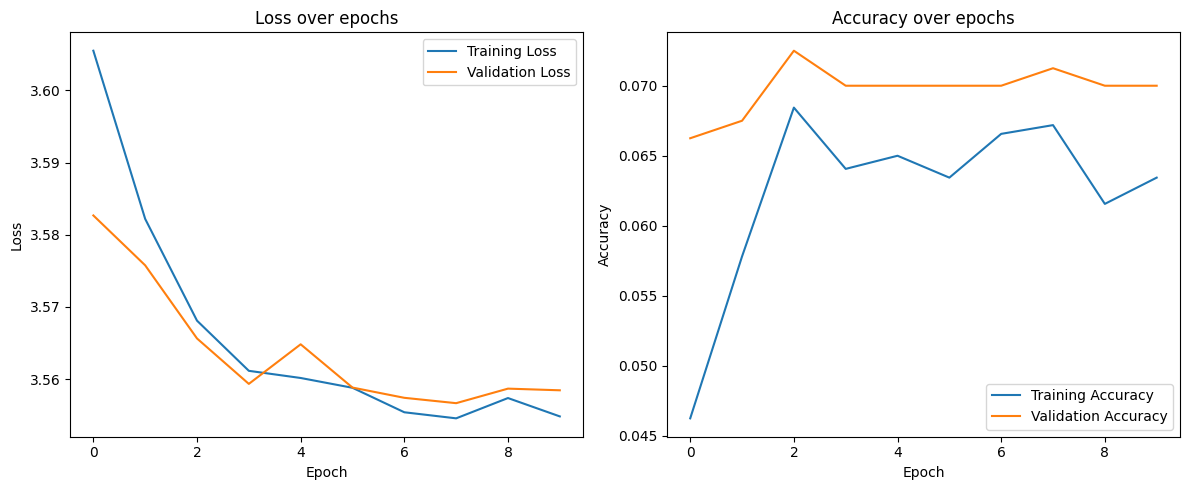

Saving model...
Evaluating model...
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step
Character-level accuracy: 0.0372
Word-level accuracy: 0.0000
Visualizing examples...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


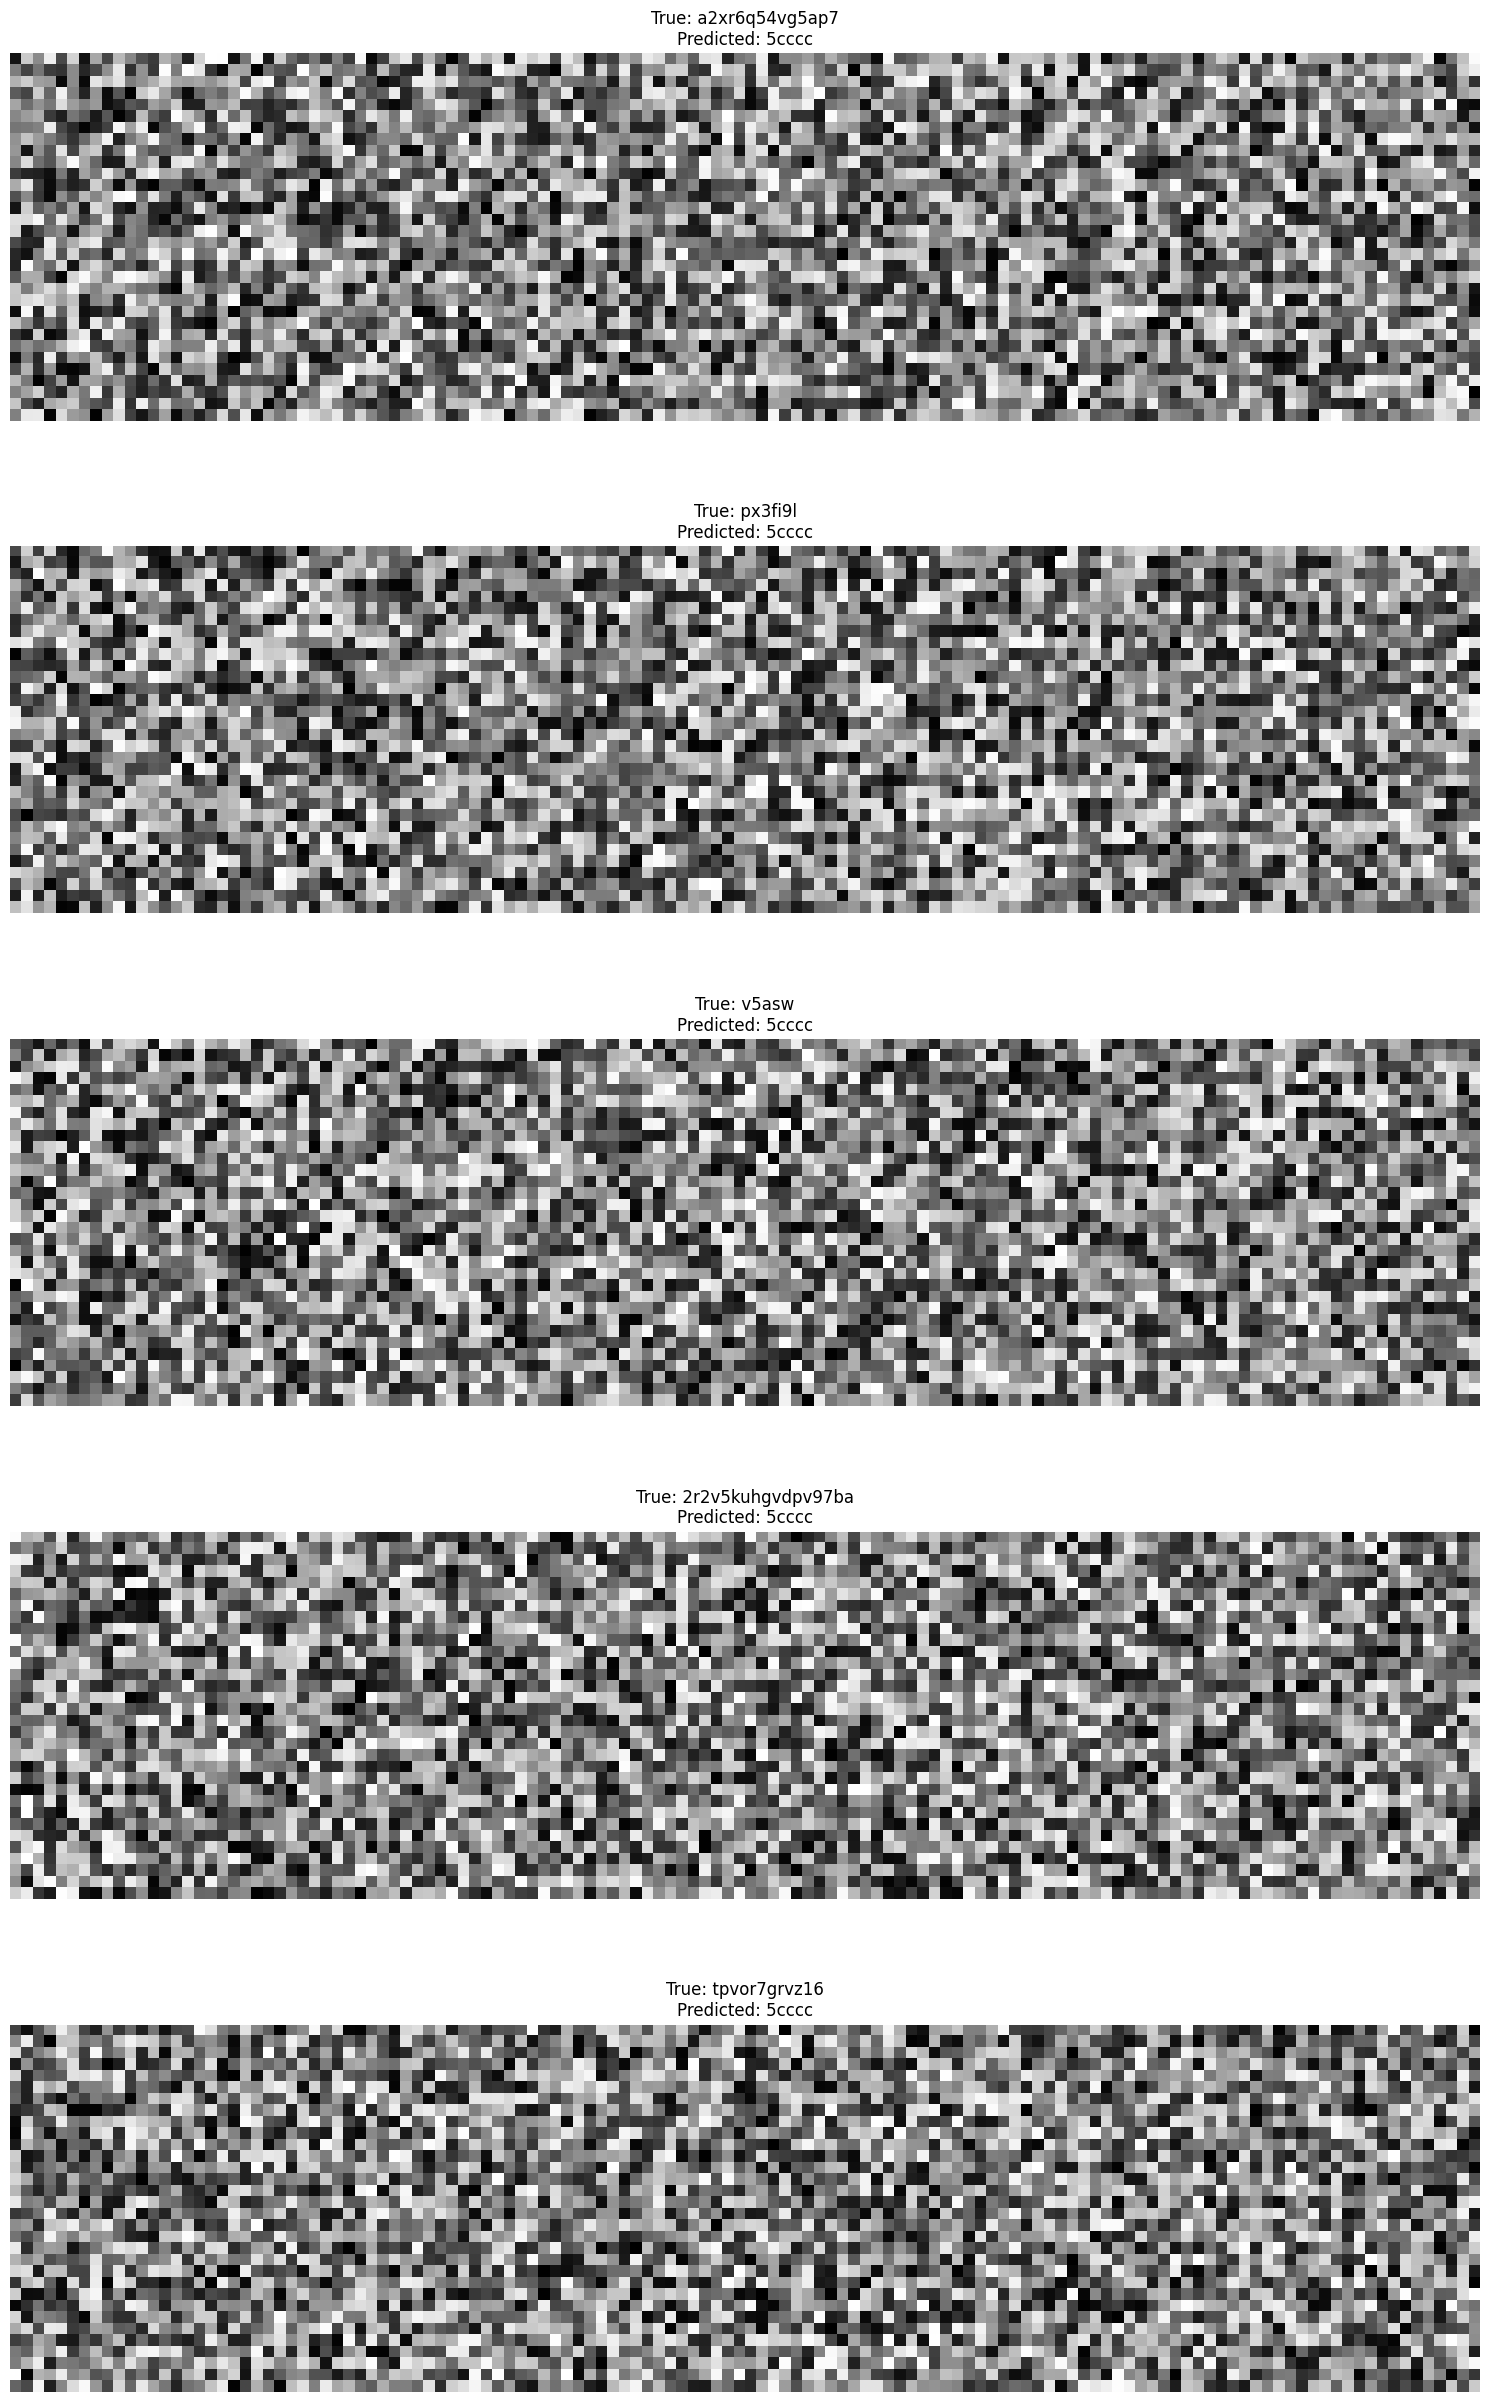



Building minimal model for EZKL compatibility...


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 32, 128, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 32, 128, 8)          │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 16, 64, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 16, 64, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 8, 32, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gap (GlobalAveragePooling2D)         │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense1 (Dense)                       │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 37)                  │           1,221 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,013 (11.77 KB)

 Trainable params: 3,013 (11.77 KB)

 Non-trainable params: 0 (0.00 B)

Training minimal EZKL-compatible model...
Epoch 1/3
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.0245 - loss: 3.6238 - val_accuracy: 0.0200 - val_loss: 3.6217
Epoch 2/3
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.0347 - loss: 3.6118 - val_accuracy: 0.0200 - val_loss: 3.6199
Epoch 3/3
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.0221 - loss: 3.6018 - val_accuracy: 0.0100 - val_loss: 3.6217


Saving minimal EZKL-compatible model...
Handwriting recognition demo completed successfully!


Starting EZKL integration process...
Starting EZKL integration with minimal model...
Exporting minimal model to ONNX format...


INFO:tf2onnx.tfonnx:Using tensorflow=2.18.0, onnx=1.17.0, tf2onnx=1.16.1/15c810
INFO:tf2onnx.tfonnx:Using opset <onnx, 11>
INFO:tf2onnx.tf_utils:Computed 0 values for constant folding
ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7f7af46f1760>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.
INFO:tf2onnx.tfonnx:['Traceback (most recent call last):\n', '  File "/usr/local/lib/python3.11/dist-packages/tf2onnx/tfonnx.py", line 375, in run_rewriters\n    ops = func(g, g.get_nodes())\n          ^^^^^^^^^^^^^^^^^^^^^^\n', '  File "/usr/local/lib/python3.11/dist-packages/tf2onnx/tfonnx.py", line 77, in rewrite_constant_fold\n    "Cast": np.cast,\n            ^^^^^^^\n', '  File "/usr/local/lib/python3.11/dist-packages/numpy/__init__.py", line 397, in __getattr__\n    raise AttributeError(\n', 'AttributeError: `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.\n']
INFO:tf2onnx.op

Model exported to models/minimal_ezkl_model.onnx
Preparing input data...
Configuring EZKL run arguments...
Generating settings...


Compiling circuit...
Generating witness...
Error generating witness: This event loop is already running


<ipython-input-65-a713cf754246>:174: RuntimeWarning: coroutine 'ezkl_integration_minimal.<locals>.run_gen_witness' was never awaited
  return


In [66]:
def main():
    """
    Main function to demonstrate handwriting recognition
    """
    print("Setting up handwriting recognition demo...")

    # Parameters
    img_height = 32
    img_width = 128
    max_label_length = 24
    batch_size = 32
    epochs = 10

    # Check if dataset exists
    data_dir = './data/images'
    label_file = './data/labels.csv'

    if os.path.exists(label_file) and os.path.isdir(data_dir):
        print("Loading real dataset...")
        images, labels, char_to_num, num_to_char, num_classes = load_data(data_dir, label_file, img_height, img_width, max_label_length)
    else:
        # Create dummy data for demonstration
        print("Real dataset not found. Creating dummy data...")
        num_samples = 500
        num_classes = 37  # 26 letters + 10 digits + blank

        # Images (batch, height, width, channels)
        images = np.random.random((num_samples, img_height, img_width, 1)).astype(np.float32)

        # Labels with variable length
        labels = np.zeros((num_samples, max_label_length), dtype=np.int32)
        for i in range(num_samples):
            length = np.random.randint(5, max_label_length)
            labels[i, :length] = np.random.randint(1, num_classes, size=length)

        # Character mappings
        char_to_num = {chr(i+97): i+1 for i in range(26)}  # a-z
        for i in range(10):
            char_to_num[str(i)] = i+27  # 0-9
        num_to_char = {v: k for k, v in char_to_num.items()}

    # BUILD REGULAR CRNN MODEL (for demonstration purposes)
    print("Building CRNN model for handwriting recognition...")
    input_shape = (img_height, img_width, 1)
    model = build_crnn_model(input_shape, num_classes, max_label_length)

    # Model summary
    model.summary()

    # Train model
    print("Training CRNN model...")
    history = train_crnn_model(
        model=model,
        images=images,
        labels=labels,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.2
    )

    # Plot training history
    plot_training_history(history)

    # Save model
    print("Saving model...")
    if not os.path.exists("models"):
        os.makedirs("models")
    model.save("models/handwriting_recognition_model.h5")

    # Evaluate model
    print("Evaluating model...")
    char_acc, word_acc, predictions = evaluate_model(model, images, labels, char_to_num, num_to_char)
    print(f"Character-level accuracy: {char_acc:.4f}")
    print(f"Word-level accuracy: {word_acc:.4f}")

    # Visualize examples
    print("Visualizing examples...")
    visualize_examples(model, images, labels, char_to_num, num_to_char)

    # BUILD MINIMAL MODEL FOR EZKL
    print("\n\nBuilding minimal model for EZKL compatibility...")
    minimal_model = build_minimal_ezkl_model(input_shape, num_classes)
    minimal_model.summary()

    # Train minimal model
    print("Training minimal EZKL-compatible model...")
    minimal_history = train_minimal_model(
        model=minimal_model,
        images=images,
        labels=labels,
        batch_size=batch_size,
        epochs=3,  # Train for fewer epochs to save time
        validation_split=0.2
    )

    # Save minimal model
    print("Saving minimal EZKL-compatible model...")
    minimal_model.save("models/minimal_ezkl_model.h5")

    print("Handwriting recognition demo completed successfully!")
    return model, minimal_model, history, char_to_num, num_to_char, images

if __name__ == "__main__":
    model, minimal_model, history, char_to_num, num_to_char, images = main()

    # Now run EZKL integration with the minimal model and images
    print("\n\nStarting EZKL integration process...")
    ezkl_integration_minimal(minimal_model, images)

ERROR:ezkl.graph:failed to load settings file at unknown variant `private`, expected one of `Private`, `Public`, `Hashed`, `KZGCommit`, `Fixed` at line 1 column 43


SRS file not found. Attempting to download...
Error downloading SRS file: Failed to get srs: [io] unknown variant `private`, expected one of `Private`, `Public`, `Hashed`, `KZGCommit`, `Fixed` at line 1 column 43
Will try again during the main integration process.
Setting up handwriting recognition demo...
Real dataset not found. Creating dummy data...
Building CRNN model for handwriting recognition...


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 32, 128, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 32, 128, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ (None, 16, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 16, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_38 (MaxPooling2D)      │ (None, 8, 32, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 8, 32, 128)          │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_39 (MaxPooling2D)      │ (None, 8, 16, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_11 (Reshape)                 │ (None, 8, 2048)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_17 (Bidirectional)     │ (None, 8, 256)              │       2,229,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_18 (Bidirectional)     │ (None, 8, 128)              │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 8, 37)               │           4,773 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,491,045 (9.50 MB)

 Trainable params: 2,491,045 (9.50 MB)

 Non-trainable params: 0 (0.00 B)

Training CRNN model...
Model output sequence length: 8
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 458ms/step - accuracy: 0.0454 - loss: 3.6100 - val_accuracy: 0.0463 - val_loss: 3.6007
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 452ms/step - accuracy: 0.0642 - loss: 3.5881 - val_accuracy: 0.0613 - val_loss: 3.5850
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 388ms/step - accuracy: 0.0637 - loss: 3.5759 - val_accuracy: 0.0487 - val_loss: 3.5820
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 426ms/step - accuracy: 0.0563 - loss: 3.5687 - val_accuracy: 0.0475 - val_loss: 3.5824
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 456ms/step - accuracy: 0.0614 - loss: 3.5611 - val_accuracy: 0.0613 - val_loss: 3.5777
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 382ms/step - accuracy: 0.0612 - loss: 3.5581 - val_accuracy: 0.0475 - val_loss: 3.5863
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 402ms/step - accuracy: 0.0532 - loss: 3.5624 - val_accuracy: 0.0475 - val_loss: 3.5800
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms

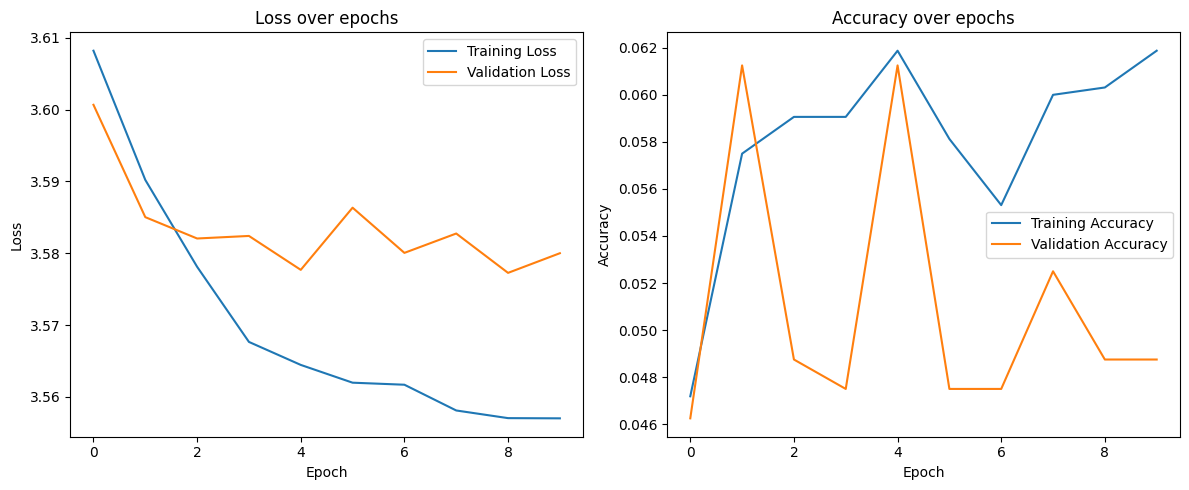

Saving model...
Evaluating model...
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step
Character-level accuracy: 0.0353
Word-level accuracy: 0.0000
Visualizing examples...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


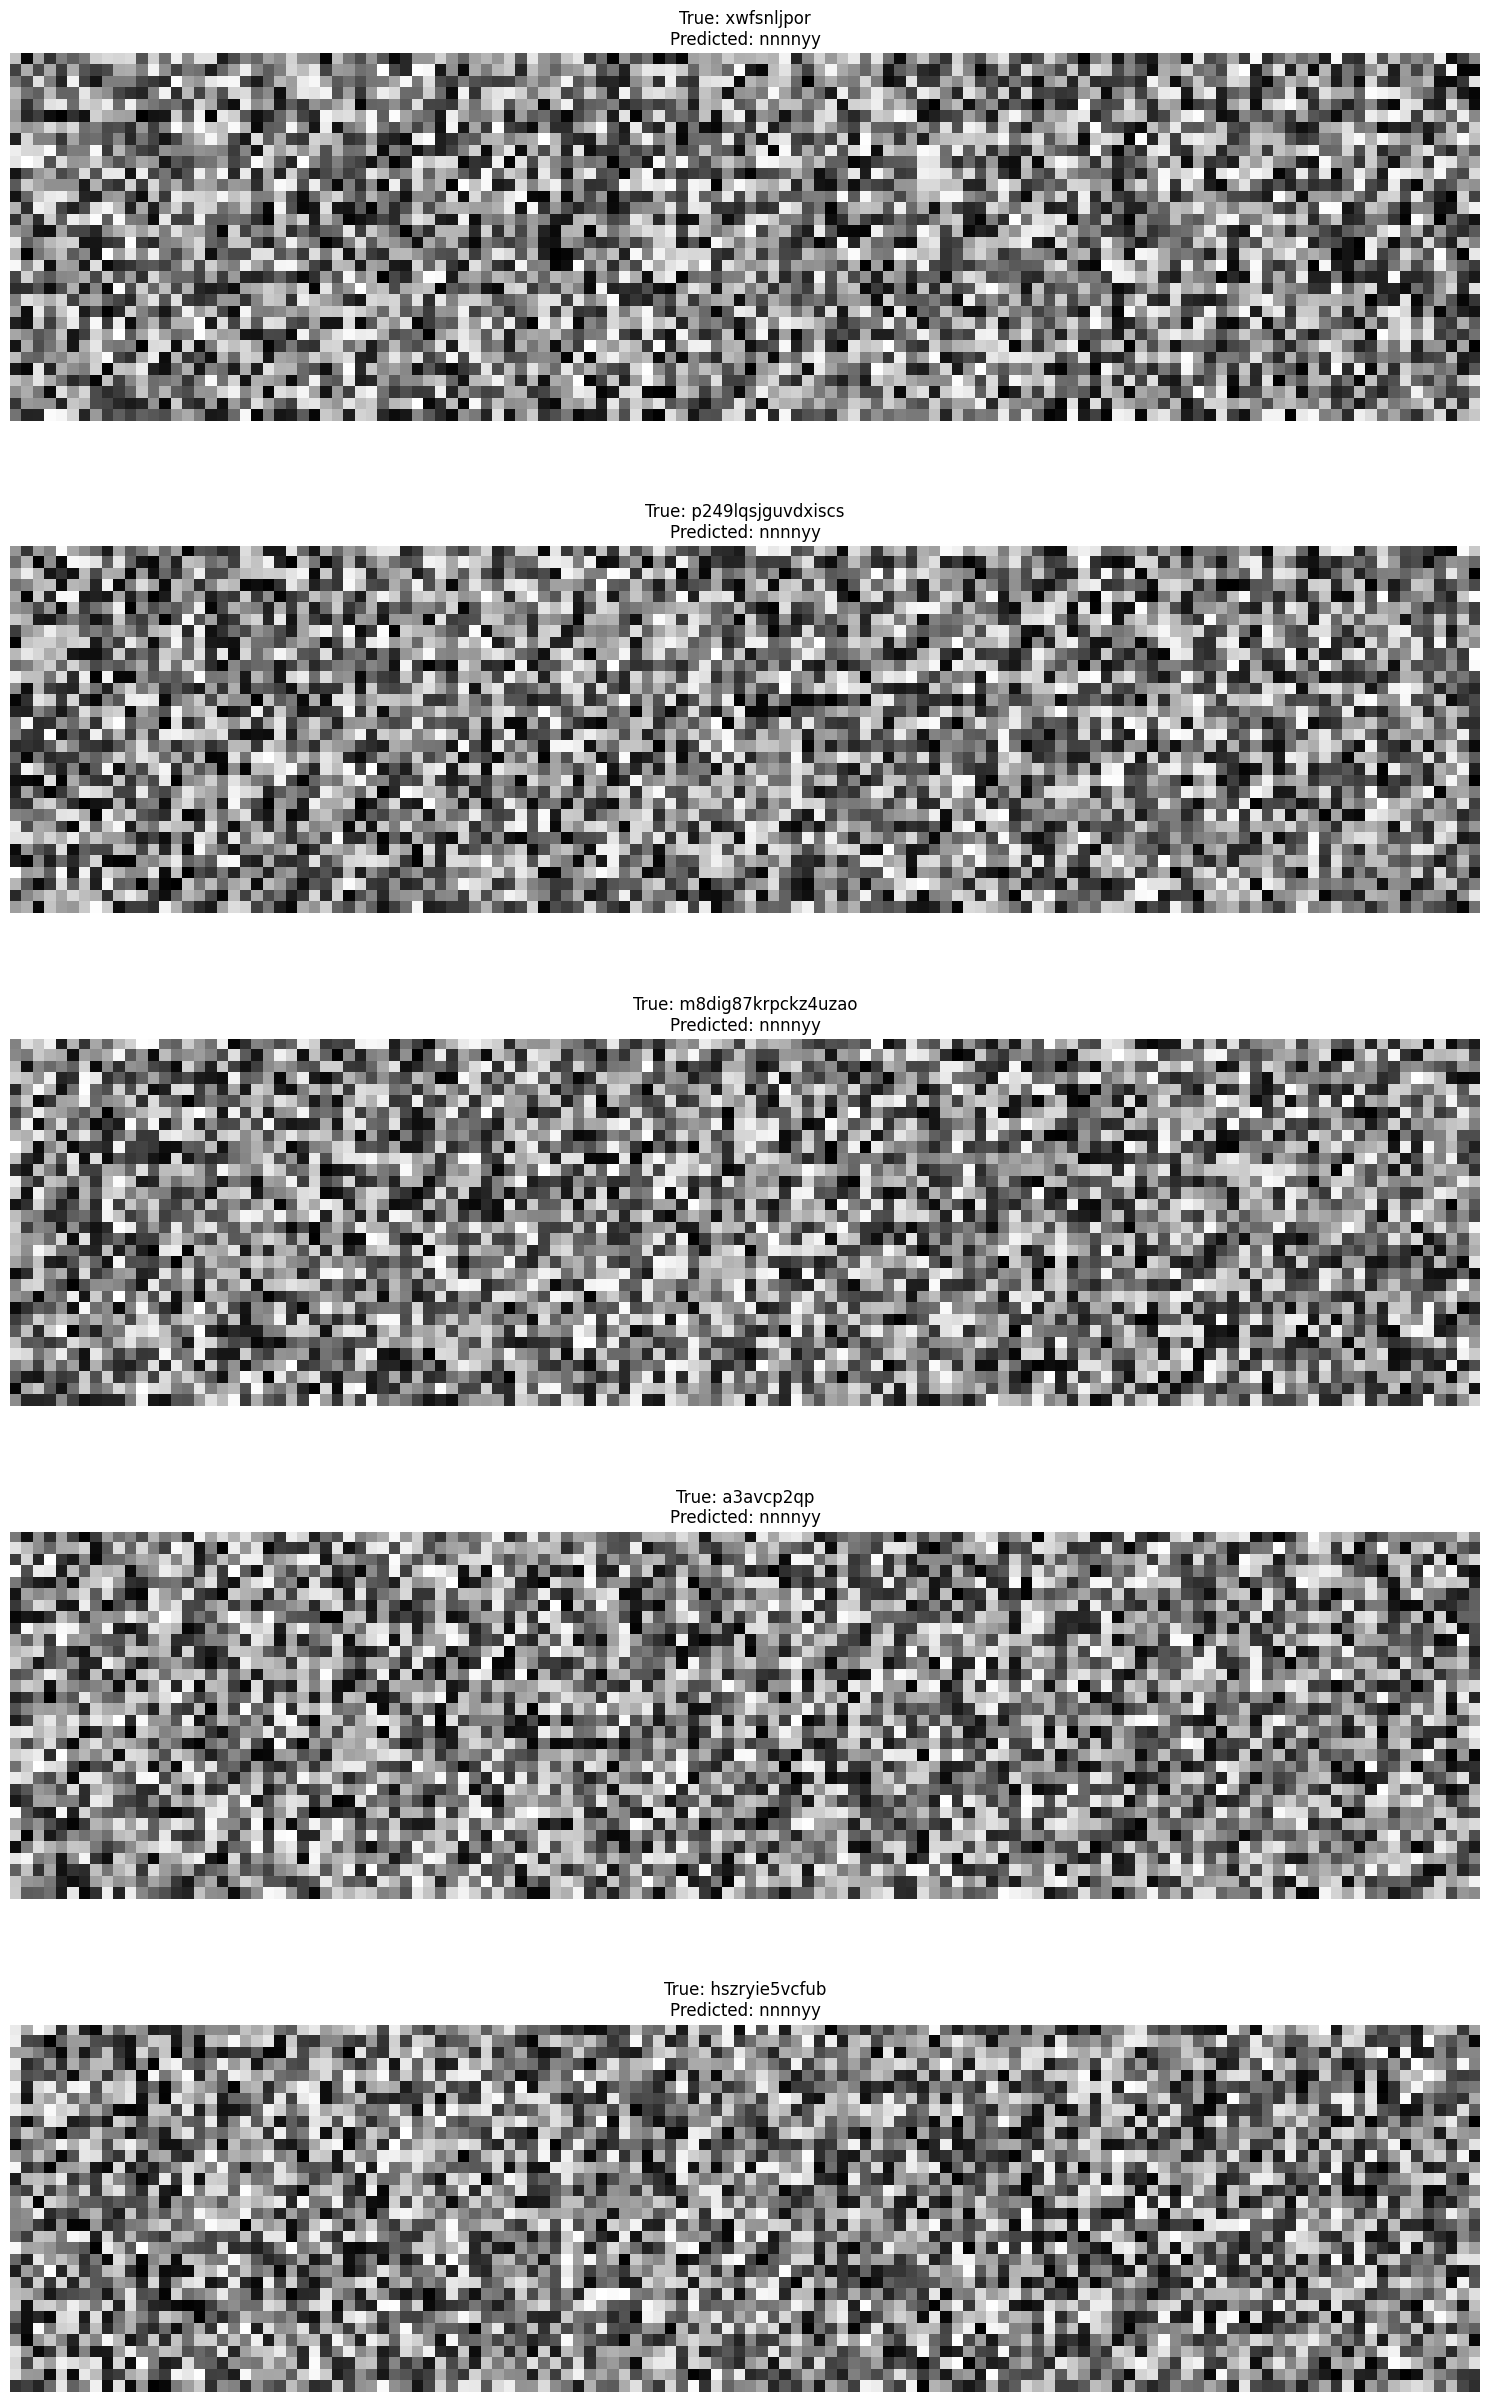



Building minimal model for EZKL compatibility...


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 32, 128, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 32, 128, 8)          │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 16, 64, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 16, 64, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 8, 32, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gap (GlobalAveragePooling2D)         │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense1 (Dense)                       │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 37)                  │           1,221 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,013 (11.77 KB)

 Trainable params: 3,013 (11.77 KB)

 Non-trainable params: 0 (0.00 B)

Training minimal EZKL-compatible model...
Epoch 1/3
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.0351 - loss: 3.6094 - val_accuracy: 0.0200 - val_loss: 3.6057
Epoch 2/3
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.0456 - loss: 3.6061 - val_accuracy: 0.0200 - val_loss: 3.6027
Epoch 3/3
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.0424 - loss: 3.5986 - val_accuracy: 0.0200 - val_loss: 3.5995


Saving minimal EZKL-compatible model...
Handwriting recognition demo completed successfully!


Starting EZKL integration process...
Starting EZKL integration with minimal model...
Exporting minimal model to ONNX format...


INFO:tf2onnx.tfonnx:Using tensorflow=2.18.0, onnx=1.17.0, tf2onnx=1.16.1/15c810
INFO:tf2onnx.tfonnx:Using opset <onnx, 11>
INFO:tf2onnx.tf_utils:Computed 0 values for constant folding
ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7f7af46f1760>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.
INFO:tf2onnx.tfonnx:['Traceback (most recent call last):\n', '  File "/usr/local/lib/python3.11/dist-packages/tf2onnx/tfonnx.py", line 375, in run_rewriters\n    ops = func(g, g.get_nodes())\n          ^^^^^^^^^^^^^^^^^^^^^^\n', '  File "/usr/local/lib/python3.11/dist-packages/tf2onnx/tfonnx.py", line 77, in rewrite_constant_fold\n    "Cast": np.cast,\n            ^^^^^^^\n', '  File "/usr/local/lib/python3.11/dist-packages/numpy/__init__.py", line 397, in __getattr__\n    raise AttributeError(\n', 'AttributeError: `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.\n']
INFO:tf2onnx.op

Model exported to models/minimal_ezkl_model.onnx
Preparing input data...
Configuring EZKL run arguments...
Generating settings...
Compiling circuit...
Generating witness...


INFO:ezkl.execute:Mock proof


Running mock verification...


INFO:ezkl.graph.model:model layout...
INFO:ezkl.circuit.table:Loading lookup table from cache: "/root/.ezkl/cache/exp_128_2.7182817_-32768_98295"
INFO:ezkl.circuit.table:Loading range check table from cache: "/root/.ezkl/cache/rangecheck_-1_1"
INFO:ezkl.circuit.table:Loading range check table from cache: "/root/.ezkl/cache/rangecheck_0_1"
INFO:ezkl.circuit.table:Loading range check table from cache: "/root/.ezkl/cache/rangecheck_0_16383"
INFO:ezkl.execute:SRS does not exist, downloading...


INFO:ezkl.execute:Saving SRS to disk...
INFO:ezkl.execute:Saved SRS to /root/.ezkl/srs/kzg17.srs.
INFO:ezkl.execute:SRS downloaded
INFO:ezkl.execute:read 16777476 bytes from file (vector of len = 16777476)
INFO:ezkl.execute:file hash: 41509f380362a8d14401c5ae92073154922fe23e45459ce6f696f58607655db7
INFO:ezkl.graph.model:model layout...


SRS download result: True
Setting up keys...


INFO:ezkl.circuit.table:Loading lookup table from cache: "/root/.ezkl/cache/exp_128_2.7182817_-32768_98295"
INFO:ezkl.circuit.table:Loading range check table from cache: "/root/.ezkl/cache/rangecheck_-1_1"
INFO:ezkl.circuit.table:Loading range check table from cache: "/root/.ezkl/cache/rangecheck_0_1"
INFO:ezkl.circuit.table:Loading range check table from cache: "/root/.ezkl/cache/rangecheck_0_16383"


In [ ]:
if __name__ == "__main__":
    # Install nest_asyncio if not already installed
    try:
        import nest_asyncio
    except ImportError:
        import subprocess
        import sys
        subprocess.check_call([sys.executable, "-m", "pip", "install", "nest_asyncio"])
        import nest_asyncio

    # Apply nest_asyncio to allow nested event loops
    nest_asyncio.apply()

    # Check for SRS file and try to download it if not present
    import asyncio
    import os

    srs_path = os.path.expanduser("~/.ezkl/srs/kzg17.srs")
    if not os.path.exists(srs_path):
        print("SRS file not found. Attempting to download...")
        try:
            # Create a temporary settings file for SRS download
            temp_settings = {
                "run_args": {
                    "input_visibility": "private",
                    "param_visibility": "fixed",
                    "output_visibility": "public"
                }
            }

            # Save temporary settings
            import json
            with open("temp_settings.json", "w") as f:
                json.dump(temp_settings, f)

            # Download SRS file
            asyncio.run(ezkl.get_srs("temp_settings.json"))
            print("SRS file downloaded successfully.")
        except Exception as e:
            print(f"Error downloading SRS file: {str(e)}")
            print("Will try again during the main integration process.")

    model, minimal_model, history, char_to_num, num_to_char, images = main()

    # Now run EZKL integration with the minimal model and images
    print("\n\nStarting EZKL integration process...")
    ezkl_integration_minimal(minimal_model, images)